# Libraries

In [2]:
# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Import the Important libraries
!pip install mat73
import mat73
import scipy.io
from sklearn.decomposition import PCA
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.metrics import roc_curve, auc
import datetime
import itertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Plotting the Confusion Metrics

In [4]:
def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)


# Isolation Forest

## Satellite dataset

In [257]:
# Loading the dataset from drive
data = scipy.io.loadmat('/content/gdrive/MyDrive/Anomaly detection/satellite.mat')
# isolate the target from the data and assign each in a variable
IF_sat = data['X']
IF_label = data['y']

In [258]:
# shape of the data
print('The shape of IForest_sat is: ', IF_sat.shape)
print('The shape of IF_label is: ', IF_label.shape)

The shape of IForest_sat is:  (6435, 36)
The shape of IF_label is:  (6435, 1)


In [259]:
# Data description
print('Multi-dimensional point data:\n',IF_sat)
print('--------------------------')
print('Labels:\n',IF_label[:5])

Multi-dimensional point data:
 [[ 92 115 120 ... 107 113  87]
 [ 84 102 106 ...  99 104  79]
 [ 84 102 102 ...  99 104  79]
 ...
 [ 56  68  91 ...  83  92  74]
 [ 56  68  87 ...  83  92  70]
 [ 60  71  91 ...  79 108  92]]
--------------------------
Labels:
 [[0]
 [0]
 [0]
 [0]
 [0]]


In [260]:
# The amount of normal and anomalies in the dataset
# 0 represents norman, 1 represents anomay
np.unique(IF_label, return_counts=True)

(array([0, 1], dtype=uint8), array([4399, 2036]))

In [261]:
# Split dataset into training, validation, and testing sets
X_train_sat, X_val_sat, y_train_sat, y_val_sat = train_test_split(IF_sat, IF_label, test_size=0.20, random_state=11)
X_val_sat, X_test_sat, y_val_sat, y_test_sat = train_test_split(X_val_sat, y_val_sat, test_size=0.50, random_state=11)
print("X_train_sat: ", len(X_train_sat), "X_val_sat: ", len(X_val_sat), "X_test_sat: ", len(X_test_sat))
print("y_train_sat: ", len(y_train_sat), "y_val_sat: ", len(y_val_sat), "y_test_sat: ", len(y_test_sat))

X_train_sat:  5148 X_val_sat:  643 X_test_sat:  644
y_train_sat:  5148 y_val_sat:  643 y_test_sat:  644


In [390]:
# define the contamination range 
contamination_range = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_range:
    # Define and train Isolation Forest model
    model = IsolationForest(random_state=20, contamination=cont, n_estimators=70, max_samples=254)
    model.fit(X_train_sat, y_train_sat)

    val_preds = model.predict(X_train_sat)
    val_preds = np.where(val_preds == -1, 1, 0)
    val_MCC = matthews_corrcoef(y_train_sat, val_preds)
    mcc_train.append(val_MCC)
    # Make predictions on the validation set
    preds = model.predict(X_val_sat)
    # convert -1 to 1 and 1 to 0
    y_preds = np.where(preds == -1, 1, 0)
    # Evaluate the performance of the model on validation set
    MCC = matthews_corrcoef(y_val_sat, y_preds)

    # Append the results to the relevant lists
    mcc_scores.append(MCC)
    contamination.append(cont)
end = datetime.datetime.now()
print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination, 2))
print('--------------------------------------------------------------------------------')
print('Relevant MCC Scores:\n', np.round(mcc_scores, 2))
print('--------------------------------------------------------------------------------')
print('Relevant MCC Scores for train:\n', np.round(mcc_train, 2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relevant MCC Scores:
 [0.15 0.23 0.27 0.32 0.34 0.37 0.41 0.43 0.46 0.48 0.48 0.5  0.51 0.53
 0.53 0.54 0.54 0.53 0.52 0.5  0.5  0.5  0.49 0.5  0.51 0.49 0.47 0.47
 0.46 0.45 0.44 0.43 0.43 0.41 0.41 0.39 0.39 0.37 0.37 0.37 0.37 0.37
 0.36 0.35 0.35 0.33 0.33 0.32 0.32 0.31]
--------------------------------------------------------------------------------
Relevant MCC Scores for train:
 [0.14 0.2  0.24 0.28 0.31 0.34 0.37 0.4  0.42 0.44 0.46 0.47 0.49 0.5
 0.5  0.5  0.5  0.5  0.5  0.48 0.48 0.49 0.48 0.47 0.47 0.46 0.45 0.45
 0.43 0.42 0.42 0.41 0.4 

In [391]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', best_contamination)

Best Contamination: 0.16


In [392]:
# Train the model on the combined training and validation set
X_train_val_sat = np.concatenate((X_train_sat, X_val_sat))
y_train_val_sat = np.concatenate((y_train_sat, y_val_sat))
model = IsolationForest(random_state=20, contamination=best_contamination, n_estimators=70, max_samples=254)
model.fit(X_train_val_sat, y_train_val_sat)

# Make predictions on the testing set
preds = model.predict(X_test_sat)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_sat, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 0.4824856459824431


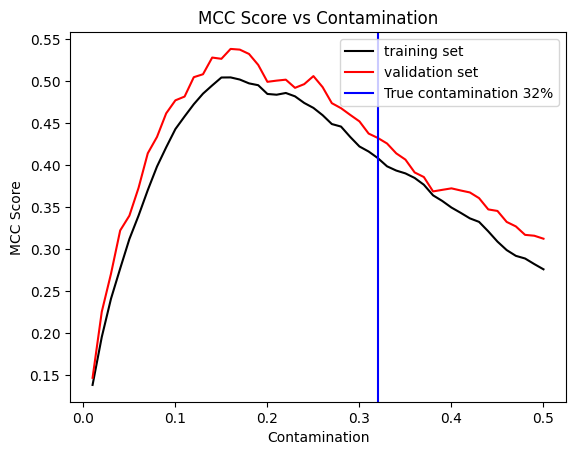

In [393]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
ax.plot(contamination_range, mcc_train, color= 'black', label = 'training set' )
ax.plot(contamination_range, mcc_scores, color= 'r', label = 'validation set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.32, color = 'b', label = 'True contamination 32%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

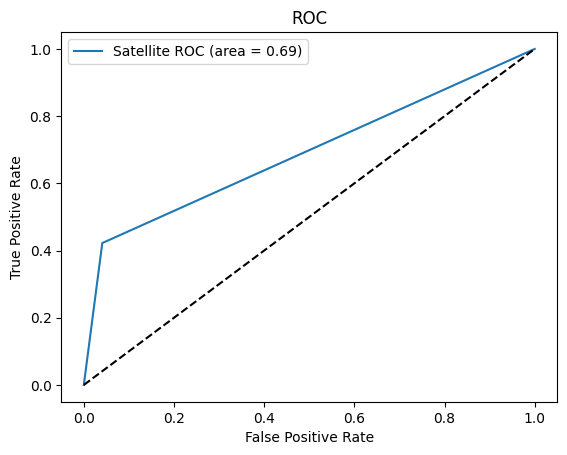

In [394]:
# plot riseiver operating characteristic
fpr, tpr, thresholds = roc_curve(y_test_sat, y_preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='Satellite ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

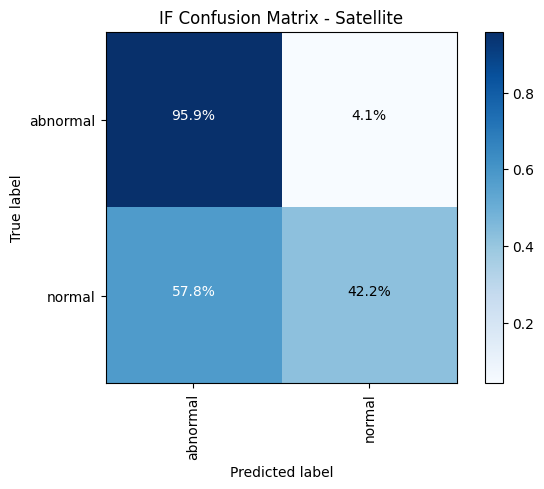

In [395]:
cm = confusion_matrix(y_test_sat, y_preds)
plot_confusion_matrix(cm, title="IF Confusion Matrix - Satellite")#, save=True, saveas="IF_SA.png")

## Shuttle dataset



In [396]:
# Loading the dataset from drive
data = scipy.io.loadmat('/content/gdrive/MyDrive/Anomaly detection/shuttle.mat')
# isolate the target from the data and assign each in a variable
IF_shut = data['X']
IF_label_shut = data['y']

In [397]:
# shape of the data
print('The shape of IF_sut is: ', IF_shut.shape)
print('The shape of IF_shut_label is: ', IF_label_shut.shape)

The shape of IF_sut is:  (49097, 9)
The shape of IF_shut_label is:  (49097, 1)


In [398]:
# Data description
print('Multi-dimensional point data:\n',IF_shut)
print('--------------------------')
print('Labels:\n',IF_label_shut[:5])

Multi-dimensional point data:
 [[ 50  21  77 ...  27  48  22]
 [ 53   0  82 ...  29  30   2]
 [ 37   0  76 ...  40  48   8]
 ...
 [ 49   0  87 ...  38  41   2]
 [ 80   0  84 ...   4 120 116]
 [ 37   0 103 ...  66  85  20]]
--------------------------
Labels:
 [[1]
 [0]
 [0]
 [0]
 [1]]


In [399]:
# The amount of normal and anomalies in the dataset
# 0 represents norman, 1 represents anomay
np.unique(IF_label_shut, return_counts=True)

(array([0, 1], dtype=uint8), array([45586,  3511]))

In [400]:
# Split dataset into training, validation, and testing sets
X_train_shut, X_val_shut, y_train_shut, y_val_shut = train_test_split(IF_shut, IF_label_shut, test_size=0.20, random_state=11)
X_val_shut, X_test_shut, y_val_shut, y_test_shut = train_test_split(X_val_shut, y_val_shut, test_size=0.50, random_state=11)
print("X_train_shut: ", len(X_train_shut), "X_val_shut: ", len(X_val_shut), "X_test_shut: ", len(X_test_shut))
print("y_train_shut: ", len(y_train_shut), "y_val_shut: ", len(y_val_shut), "y_test_shut: ", len(y_test_shut))

X_train_shut:  39277 X_val_shut:  4910 X_test_shut:  4910
y_train_shut:  39277 y_val_shut:  4910 y_test_shut:  4910


In [401]:
# define the contamination range 
contamination_range = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_range:
    # Define and train Isolation Forest model
    model = IsolationForest(random_state=20, contamination=cont, n_estimators=95, max_samples=229)
    model.fit(X_train_shut, y_train_shut)
# make prediction in training dataset
    val_preds = model.predict(X_train_shut)
    val_preds = np.where(val_preds == -1, 1, 0)
    val_MCC = matthews_corrcoef(y_train_shut, val_preds)
    mcc_train.append(val_MCC)
    # Make predictions on the validation set
    preds = model.predict(X_val_shut)
    # convert -1 to 1 and 1 to 0
    y_preds = np.where(preds == -1, 1, 0)
    # Evaluate the performance of the model on validation set
    MCC = matthews_corrcoef(y_val_shut, y_preds)
    # Append the results to the relevant lists
    mcc_scores.append(MCC)
    contamination.append(cont)
end = datetime.datetime.now()
print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination, 2))
print('--------------------------------------------------------------------------------')
print('Relevant MCC Scores:\n', np.round(mcc_scores, 2))
print('--------------------------------------------------------------------------------')
print('Relevant MCC Scores for train:\n', np.round(mcc_train, 2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relevant MCC Scores:
 [0.36 0.51 0.62 0.72 0.81 0.89 0.96 0.93 0.87 0.82 0.78 0.74 0.7  0.66
 0.64 0.61 0.59 0.57 0.55 0.53 0.52 0.51 0.49 0.48 0.46 0.45 0.44 0.43
 0.42 0.41 0.4  0.39 0.38 0.38 0.37 0.36 0.35 0.34 0.34 0.33 0.32 0.32
 0.31 0.3  0.3  0.29 0.29 0.28 0.28 0.27]
--------------------------------------------------------------------------------
Relevant MCC Scores for train:
 [0.36 0.51 0.63 0.73 0.82 0.9  0.96 0.93 0.87 0.82 0.78 0.74 0.71 0.68
 0.66 0.63 0.61 0.59 0.57 0.55 0.54 0.52 0.51 0.49 0.48 0.47 0.46 0.45
 0.43 0.42 0.41 0.41 0.4

In [402]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', np.round(best_contamination,2))

Best Contamination: 0.07


In [403]:
# Train the model on the combined training and validation set
X_train_val_shut = np.concatenate((X_train_shut, X_val_shut))
y_train_val_shut = np.concatenate((y_train_shut, y_val_shut))
model = IsolationForest(random_state=20, contamination=best_contamination, n_estimators=95, max_samples=229)
model.fit(X_train_val_shut, y_train_val_shut)

# Make predictions on the testing set
preds = model.predict(X_test_shut)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_shut, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 0.963858017751796


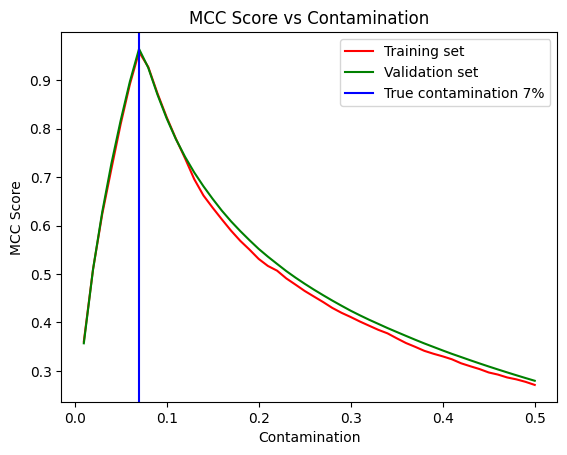

In [404]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
ax.plot(contamination_range, mcc_scores, color= 'r', label = 'Training set')
ax.plot(contamination_range, mcc_train, color= 'g', label = 'Validation set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.07, color = 'b', label = 'True contamination 7%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

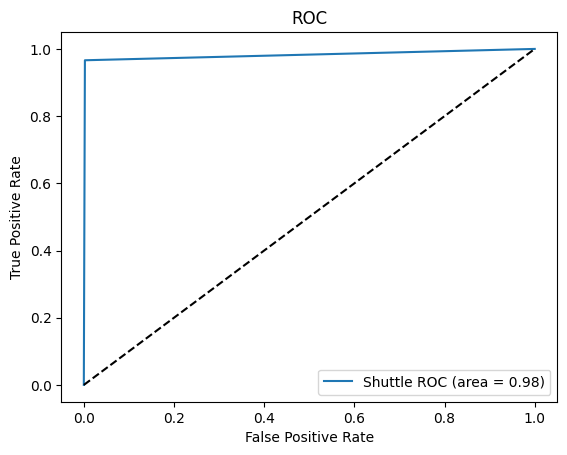

In [405]:
# plot riseiver operating characteristic
fpr1, tpr1, thresholds1 = roc_curve(y_test_shut, y_preds)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Shuttle ROC (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

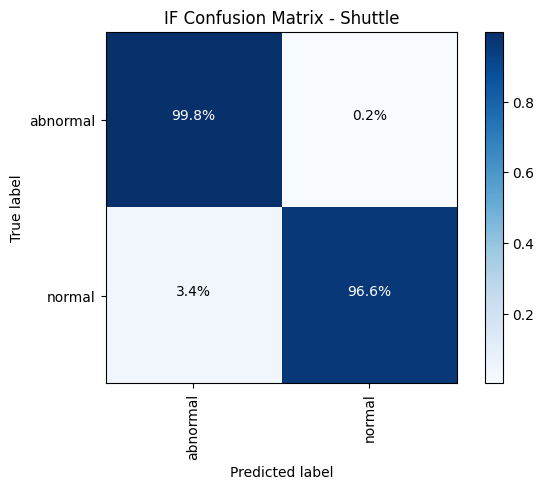

In [406]:
cm = confusion_matrix(y_test_shut, y_preds)
plot_confusion_matrix(cm, title="IF Confusion Matrix - Shuttle")

## BreastW dataset

In [407]:
# Loading the dataset from drive
data = scipy.io.loadmat('/content/gdrive/MyDrive/Anomaly detection/breastw.mat')
# isolate the target from the data and assign each in a variable
IF_breast = data['X']
IF_label_breast = data['y']

In [408]:
# shape of the data
print('The shape of IF_breat is: ', IF_breast.shape)
print('The shape of IF_label_breast is: ', IF_label_breast.shape)

The shape of IF_breat is:  (683, 9)
The shape of IF_label_breast is:  (683, 1)


In [409]:
# Data description
print('Multi-dimensional point data:\n',IF_breast)
print('--------------------------')
print('Labels:\n',IF_label_breast[:5])

Multi-dimensional point data:
 [[ 5  1  1 ...  3  1  1]
 [ 5  4  4 ...  3  2  1]
 [ 3  1  1 ...  3  1  1]
 ...
 [ 5 10 10 ...  8 10  2]
 [ 4  8  6 ... 10  6  1]
 [ 4  8  8 ... 10  4  1]]
--------------------------
Labels:
 [[0]
 [0]
 [0]
 [0]
 [0]]


In [410]:
# The amount of normal and anomalies in the dataset
# 0 represents norman, 1 represents anomay
np.unique(IF_label_breast, return_counts=True)

(array([0, 1], dtype=uint8), array([444, 239]))

In [411]:
# Split dataset into training, validation, and testing sets
X_train_breast, X_val_breast, y_train_breast, y_val_breast = train_test_split(IF_breast, IF_label_breast, test_size=0.20, random_state=11)
X_val_breast, X_test_breast, y_val_breast, y_test_breast = train_test_split(X_val_breast, y_val_breast, test_size=0.50, random_state=11)
print("X_train_breast: ", len(X_train_breast), "X_val_breast: ", len(X_val_breast), "X_test_breast: ", len(X_test_breast))
print("y_train_breast: ", len(y_train_breast), "y_val_breast: ", len(y_val_breast), "y_test_breast: ", len(y_test_breast))

X_train_breast:  546 X_val_breast:  68 X_test_breast:  69
y_train_breast:  546 y_val_breast:  68 y_test_breast:  69


In [479]:
# define the contamination range 
contamination_range = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_range:
    # Define and train Isolation Forest model
    model = IsolationForest(random_state=20, contamination=cont, n_estimators=15, max_samples=30)
    model.fit(X_train_breast, y_train_breast)
    # make prediction in training dataset
    val_preds = model.predict(X_train_breast)
    val_preds = np.where(val_preds == -1, 1, 0)
    val_MCC = matthews_corrcoef(y_train_breast, val_preds)
    mcc_train.append(val_MCC)
    # Make predictions on the validation set
    preds = model.predict(X_val_breast)
    # convert -1 to 1 and 1 to 0
    y_preds = np.where(preds == -1, 1, 0)
    # Evaluate the performance of the model on validation set
    MCC = matthews_corrcoef(y_val_breast, y_preds)
    # Append the results to the relevant lists
    mcc_scores.append(MCC)
    contamination.append(cont)
end = datetime.datetime.now()
print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination, 2))
print('--------------------------------------------------------------------------------')
print('Relevant MCC Scores for training dataset:\n', np.round(mcc_train, 2))
print('--------------------------------------------------------------------------------')
print('Relevant MCC Scores:\n', np.round(mcc_scores, 2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relevant MCC Scores for training dataset:
 [0.15 0.2  0.23 0.28 0.31 0.35 0.37 0.4  0.42 0.46 0.48 0.48 0.53 0.55
 0.58 0.58 0.59 0.61 0.64 0.66 0.68 0.7  0.72 0.73 0.75 0.76 0.78 0.8
 0.82 0.84 0.85 0.88 0.89 0.91 0.92 0.92 0.92 0.91 0.9  0.88 0.87 0.85
 0.83 0.82 0.8  0.79 0.77 0.76 0.74 0.72]
--------------------------------------------------------------------------------
Relevant MCC Scores:
 [0.   0.   0.17 0.17 0.35 0.39 0.44 0.44 0.44 0.44 0.47 0.47 0.51 0.55
 0.58 0.61 0.65 0.68 0.68 0.71 0.74 0.78 0.78 0.78 0.81 0.81 0.84 0.84
 0.87 0.87 0.9

In [480]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', np.round(best_contamination,2))

Best Contamination: 0.36


In [481]:
# Train the model on the combined training and validation set
X_train_val_breast = np.concatenate((X_train_breast, X_val_breast))
y_train_val_breast = np.concatenate((y_train_breast, y_val_breast))
model = IsolationForest(random_state=20, contamination=best_contamination, n_estimators=15, max_samples=30)
model.fit(X_train_val_breast, y_train_val_breast)

# Make predictions on the testing set
preds = model.predict(X_test_breast)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_breast, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 1.0


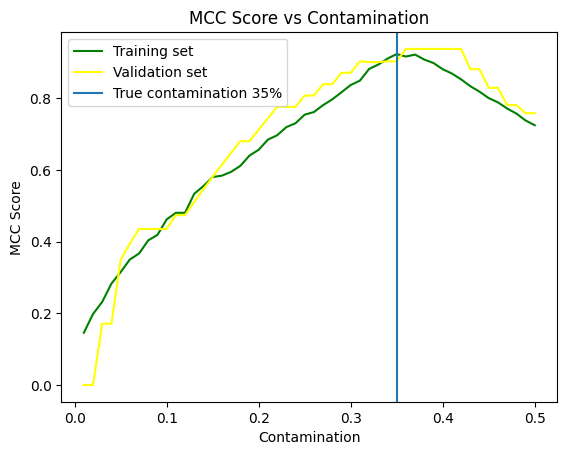

In [482]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
ax.plot(contamination_range, mcc_train, color= 'g', label = 'Training set')
ax.plot(contamination_range, mcc_scores, color= 'yellow', label = 'Validation set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.35, label = 'True contamination 35%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

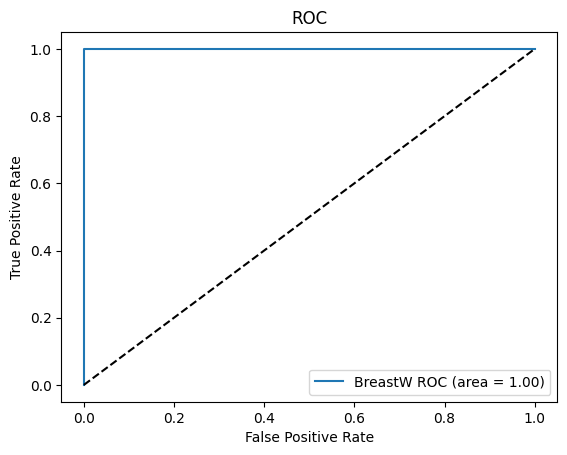

In [483]:
# plot riseiver operating characteristic
fpr2, tpr2, thresholds2 = roc_curve(y_test_breast, y_preds)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='BreastW ROC (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

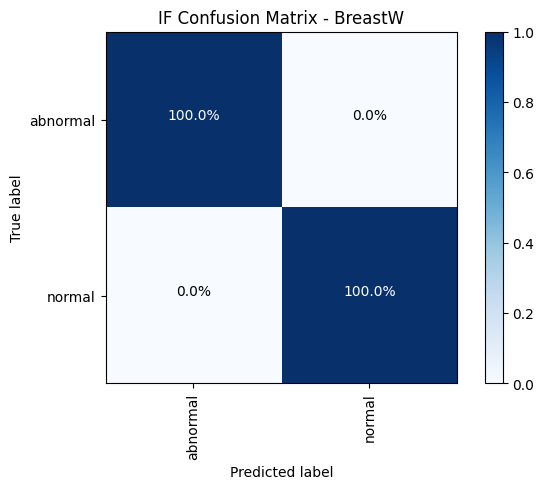

In [484]:
cm = confusion_matrix(y_test_breast, y_preds)
plot_confusion_matrix(cm, title="IF Confusion Matrix - BreastW")

## Ionosphere dataset

In [485]:
# Loading the dataset from drive
data = scipy.io.loadmat('/content/gdrive/MyDrive/Anomaly detection/ionosphere.mat')
# isolate the target from the data and assign each in a variable
IF_ion = data['X']
IF_label_ion = data['y']

In [486]:
# shape of the data
print('The shape of IF_ion is: ', IF_ion.shape)
print('The shape of IF_label_ion is: ', IF_label_ion.shape)

The shape of IF_ion is:  (351, 33)
The shape of IF_label_ion is:  (351, 1)


In [487]:
# Data description
print('Multi-dimensional point data:\n',IF_ion)
print('--------------------------')
print('Labels:\n',IF_label_ion[:5])

Multi-dimensional point data:
 [[ 1.0000e+00  9.9539e-01 -5.8890e-02 ... -5.4487e-01  1.8641e-01
  -4.5300e-01]
 [ 1.0000e+00  1.0000e+00 -1.8829e-01 ... -6.2880e-02 -1.3738e-01
  -2.4470e-02]
 [ 1.0000e+00  1.0000e+00 -3.3650e-02 ... -2.4180e-01  5.6045e-01
  -3.8238e-01]
 ...
 [ 1.0000e+00  9.4701e-01 -3.4000e-04 ...  4.4200e-03  9.2697e-01
  -5.7700e-03]
 [ 1.0000e+00  9.0608e-01 -1.6570e-02 ... -3.7570e-02  8.7403e-01
  -1.6243e-01]
 [ 1.0000e+00  8.4710e-01  1.3533e-01 ... -6.6780e-02  8.5764e-01
  -6.1510e-02]]
--------------------------
Labels:
 [[0]
 [1]
 [0]
 [1]
 [0]]


In [488]:
# The amount of normal and anomalies in the dataset
# 0 represents norman, 1 represents anomay
np.unique(IF_label_ion, return_counts=True)

(array([0, 1], dtype=uint8), array([225, 126]))

In [489]:
# Split dataset into training, validation, and testing sets
X_train_ion, X_val_ion, y_train_ion, y_val_ion = train_test_split(IF_ion, IF_label_ion, test_size=0.20, random_state=11)
X_val_ion, X_test_ion, y_val_ion, y_test_ion = train_test_split(X_val_ion, y_val_ion, test_size=0.50, random_state=11)
print("X_train_ion: ", len(X_train_ion), "X_val_ion: ", len(X_val_ion), "X_test_ion: ", len(X_test_ion))
print("y_train_ion: ", len(y_train_ion), "y_val_ion: ", len(y_val_ion), "y_test_ion: ", len(y_test_ion))

X_train_ion:  280 X_val_ion:  35 X_test_ion:  36
y_train_ion:  280 y_val_ion:  35 y_test_ion:  36


In [552]:
# define the contamination range 
contamination_range = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_range:
    # Define and train Isolation Forest model
    model = IsolationForest(random_state=20, contamination=cont, n_estimators=5, max_samples=120)
    model.fit(X_train_ion, y_train_ion)
    # make prediction in training dataset
    val_preds = model.predict(X_train_ion)
    val_preds = np.where(val_preds == -1, 1, 0)
    val_MCC = matthews_corrcoef(y_train_ion, val_preds)
    mcc_train.append(val_MCC)
    # Make predictions on the validation set
    preds = model.predict(X_val_ion)
    # convert -1 to 1 and 1 to 0
    y_preds = np.where(preds == -1, 1, 0)
    # Evaluate the performance of the model on validation set
    MCC = matthews_corrcoef(y_val_ion, y_preds)
    # Append the results to the relevant lists
    mcc_scores.append(MCC)
    contamination.append(cont)
end = datetime.datetime.now()
print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination, 2))
print('--------------------------------------------------------------------------------')
print('Relevant MCC Scores for training set:\n', np.round(mcc_train, 2))
print('--------------------------------------------------------------------------------')
print('Relevant MCC Scores:\n', np.round(mcc_scores, 2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relevant MCC Scores for training set:
 [0.14 0.2  0.24 0.26 0.31 0.34 0.37 0.4  0.43 0.45 0.47 0.48 0.46 0.46
 0.48 0.49 0.51 0.52 0.5  0.5  0.47 0.49 0.49 0.51 0.5  0.53 0.55 0.54
 0.54 0.57 0.55 0.54 0.52 0.54 0.52 0.53 0.52 0.5  0.5  0.47 0.47 0.47
 0.45 0.47 0.45 0.43 0.42 0.4  0.39 0.4 ]
--------------------------------------------------------------------------------
Relevant MCC Scores:
 [0.   0.   0.22 0.22 0.22 0.22 0.4  0.4  0.4  0.4  0.28 0.36 0.36 0.43
 0.5  0.43 0.43 0.43 0.49 0.49 0.49 0.49 0.49 0.43 0.43 0.43 0.57 0.51
 0.58 0.6  0.6  0

In [553]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', np.round(best_contamination,2))

Best Contamination: 0.3


In [556]:
# Train the model on the combined training and validation set
X_train_val_ion = np.concatenate((X_train_ion, X_val_ion))
y_train_val_ion = np.concatenate((y_train_ion, y_val_ion))
model = IsolationForest(random_state=20, contamination=best_contamination, n_estimators=5, max_samples=120)
model.fit(X_train_val_ion, y_train_val_ion)

# Make predictions on the testing set
preds = model.predict(X_test_ion)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_ion, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 0.4498234510602419


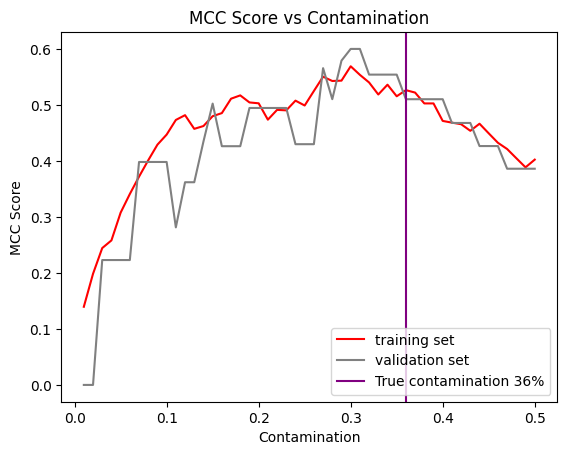

In [557]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
ax.plot(contamination_range, mcc_train, color= 'red', label = 'training set')
ax.plot(contamination_range, mcc_scores, color= 'gray', label = 'validation set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.36, color = 'purple', label = 'True contamination 36%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

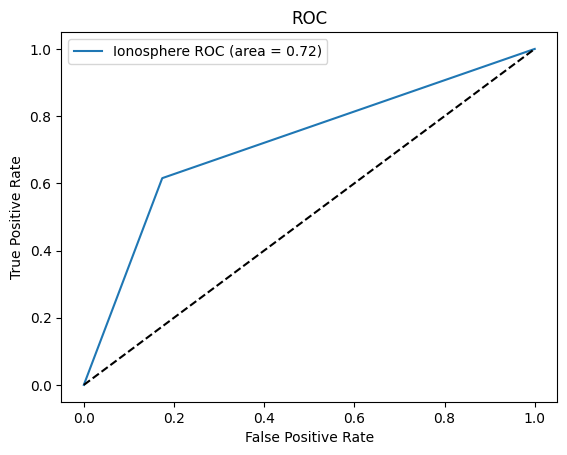

In [558]:
# plot riseiver operating characteristic
fpr3, tpr3, thresholds3 = roc_curve(y_test_ion, y_preds)
roc_auc3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Ionosphere ROC (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

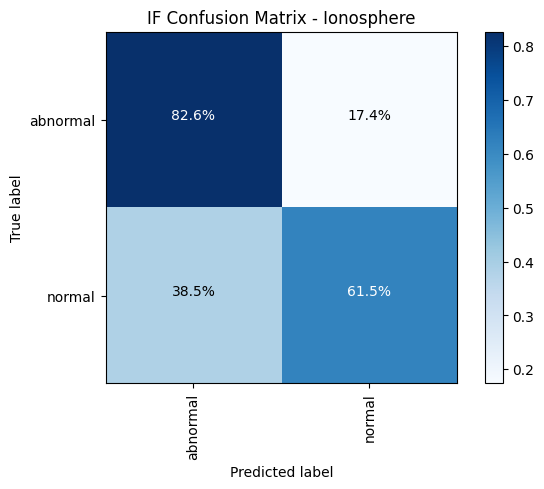

In [559]:
cm = confusion_matrix(y_test_ion, y_preds)
plot_confusion_matrix(cm, title="IF Confusion Matrix - Ionosphere")

## Thyroid dataset

In [352]:
# Loading the dataset from drive
data = scipy.io.loadmat('/content/gdrive/MyDrive/Anomaly detection/annthyroid.mat')
# isolate the target from the data and assign each in a variable
IF_ann = data['X']
IF_label_ann = data['y']

In [318]:
# shape of the data
print('The shape of IF_ann is: ', IF_ann.shape)
print('The shape of IF_label_ann is: ', IF_label_ann.shape)

The shape of IF_ann is:  (7200, 6)
The shape of IF_label_ann is:  (7200, 1)


In [319]:
# Data description
print('Multi-dimensional point data:\n',IF_ann)
print('--------------------------')
print('Labels:\n',IF_label_ann[:5])

Multi-dimensional point data:
 [[7.30e-01 6.00e-04 1.50e-02 1.20e-01 8.20e-02 1.46e-01]
 [2.40e-01 2.50e-04 3.00e-02 1.43e-01 1.33e-01 1.08e-01]
 [4.70e-01 1.90e-03 2.40e-02 1.02e-01 1.31e-01 7.80e-02]
 ...
 [5.10e-01 7.60e-04 2.01e-02 9.00e-02 6.70e-02 1.34e-01]
 [3.50e-01 2.80e-03 2.01e-02 9.00e-02 8.90e-02 1.01e-01]
 [7.30e-01 5.60e-04 2.01e-02 8.10e-02 9.00e-02 9.00e-02]]
--------------------------
Labels:
 [[0]
 [0]
 [0]
 [0]
 [0]]


In [320]:
# The amount of normal and anomalies in the dataset
# 0 represents norman, 1 represents anomay
np.unique(IF_label_ann, return_counts=True)

(array([0, 1], dtype=uint8), array([6666,  534]))

In [321]:
# Split dataset into training, validation, and testing sets
X_train_ann, X_val_ann, y_train_ann, y_val_ann = train_test_split(IF_ann, IF_label_ann, test_size=0.20, random_state=11)
X_val_ann, X_test_ann, y_val_ann, y_test_ann = train_test_split(X_val_ann, y_val_ann, test_size=0.50, random_state=11)
print("X_train_ann: ", len(X_train_ann), "X_val_ann: ", len(X_val_ann), "X_test_ann: ", len(X_test_ann))
print("y_train_ann: ", len(y_train_ann), "y_val_ann: ", len(y_val_ann), "y_test_ann: ", len(y_test_ann))

X_train_ann:  5760 X_val_ann:  720 X_test_ann:  720
y_train_ann:  5760 y_val_ann:  720 y_test_ann:  720


In [628]:
# define the contamination range 
contamination_range = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_range:
    # Define and train Isolation Forest model
    model = IsolationForest(random_state=20, contamination=cont, n_estimators=90, max_samples=150)
    model.fit(X_train_ann, y_train_ann)
    # make prediction in training dataset
    val_preds = model.predict(X_train_ann)
    val_preds = np.where(val_preds == -1, 1, 0)
    val_MCC = matthews_corrcoef(y_train_ann, val_preds)
    mcc_train.append(val_MCC)
    # Make predictions on the validation set
    preds = model.predict(X_val_ann)
    # convert -1 to 1 and 1 to 0
    y_preds = np.where(preds == -1, 1, 0)
    # Evaluate the performance of the model on validation set
    MCC = matthews_corrcoef(y_val_ann, y_preds)
    # Append the results to the relevant lists
    mcc_scores.append(MCC)
    contamination.append(cont)
end = datetime.datetime.now()
print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination, 2))
print('--------------------------------------------------------------------------------')
print('Relevant MCC Scores for train set:\n', np.round(mcc_train, 2))
print('--------------------------------------------------------------------------------')
print('Relevant MCC Scores:\n', np.round(mcc_scores, 2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relevant MCC Scores for train set:
 [0.2  0.25 0.28 0.29 0.29 0.29 0.29 0.29 0.28 0.29 0.3  0.3  0.3  0.31
 0.3  0.3  0.3  0.3  0.3  0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.28
 0.28 0.28 0.27 0.27 0.27 0.27 0.26 0.26 0.26 0.26 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.24 0.24 0.24]
--------------------------------------------------------------------------------
Relevant MCC Scores:
 [0.26 0.36 0.32 0.26 0.24 0.27 0.26 0.29 0.29 0.32 0.34 0.36 0.34 0.36
 0.36 0.36 0.35 0.35 0.34 0.33 0.32 0.33 0.32 0.31 0.31 0.31 0.3  0.29
 0.3  0.28 0.29 0.29

In [629]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', np.round(best_contamination,2))

Best Contamination: 0.16


In [634]:
# Train the model on the combined training and validation set
X_train_val_ann = np.concatenate((X_train_ann, X_val_ann))
y_train_val_ann = np.concatenate((y_train_ann, y_val_ann))
model = IsolationForest(random_state=20, contamination=best_contamination, n_estimators=90, max_samples=150)
model.fit(X_train_val_ann, y_train_val_ann)

# Make predictions on the testing set
preds = model.predict(X_test_ann)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_ann, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 0.27992656006716254


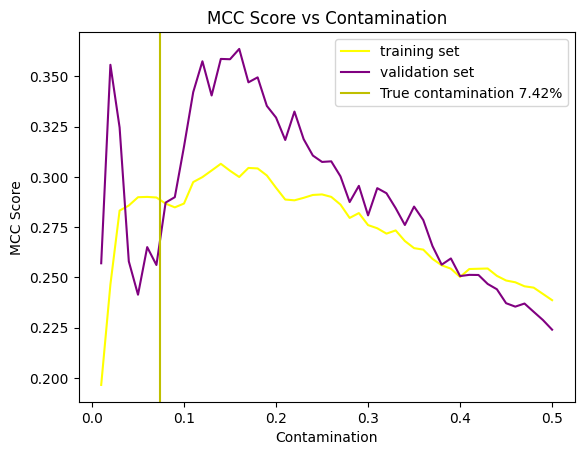

In [635]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
ax.plot(contamination_range, mcc_train, color= 'yellow', label = 'training set')
ax.plot(contamination_range, mcc_scores, color= 'purple', label = 'validation set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.0742, color = 'y', label = 'True contamination 7.42%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

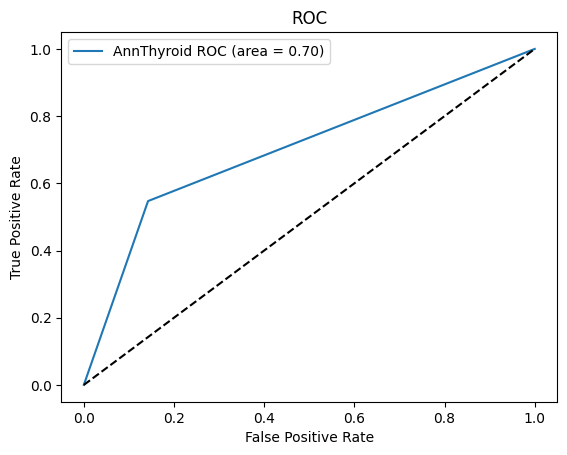

In [636]:
# plot riseiver operating characteristic
fpr4, tpr4, thresholds4 = roc_curve(y_test_ann, y_preds)
roc_auc4 = auc(fpr4, tpr4)
plt.plot(fpr4, tpr4, label='AnnThyroid ROC (area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

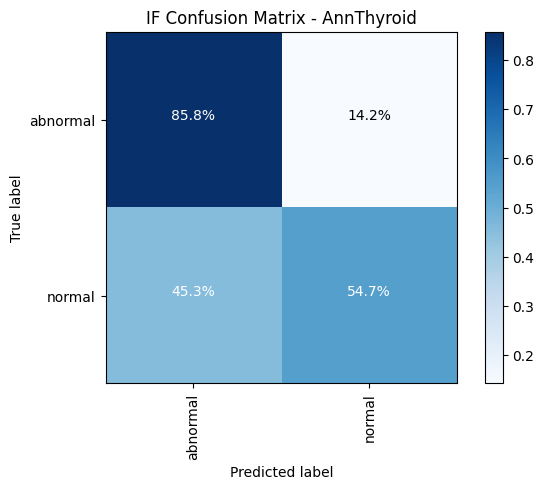

In [637]:
cm = confusion_matrix(y_test_ann, y_preds)
plot_confusion_matrix(cm, title="IF Confusion Matrix - AnnThyroid")

## Forest Cover dataset

In [638]:
# Loading the dataset from drive
data = scipy.io.loadmat('/content/gdrive/MyDrive/Anomaly detection/cover.mat')
# isolate the target from the data and assign each in a variable
IF_cover = data['X']
IF_label_cover = data['y']

In [639]:
# shape of the data
print('The shape of IF_cover is: ', IF_cover.shape)
print('The shape of IF_label_cover is: ', IF_label_cover.shape)

The shape of IF_cover is:  (286048, 10)
The shape of IF_label_cover is:  (286048, 1)


In [640]:
# Data description
print('Multi-dimensional point data:\n',IF_cover)
print('--------------------------')
print('Labels:\n',IF_label_cover[:5])

Multi-dimensional point data:
 [[2804  139    9 ...  238  135 6121]
 [2785  155   18 ...  238  122 6211]
 [2579  132    6 ...  237  140 6031]
 ...
 [2612   17   13 ...  211  138  644]
 [2610   16   14 ...  211  138  671]
 [2608   23   14 ...  209  131  698]]
--------------------------
Labels:
 [[0]
 [0]
 [0]
 [0]
 [0]]


In [641]:
# The amount of normal and anomalies in the dataset
# 0 represents norman, 1 represents anomay
np.unique(IF_label_cover, return_counts=True)

(array([0, 1], dtype=uint8), array([283301,   2747]))

In [642]:
# Split dataset into training, validation, and testing sets
X_train_cover, X_val_cover, y_train_cover, y_val_cover = train_test_split(IF_cover, IF_label_cover, test_size=0.20, random_state=11)
X_val_cover, X_test_cover, y_val_cover, y_test_cover = train_test_split(X_val_cover, y_val_cover, test_size=0.50, random_state=11)
print("X_train_cover: ", len(X_train_cover), "X_val_cover: ", len(X_val_cover), "X_test_cover: ", len(X_test_cover))
print("y_train_cover: ", len(y_train_cover), "y_val_cover: ", len(y_val_cover), "y_test_cover: ", len(y_test_cover))

X_train_cover:  228838 X_val_cover:  28605 X_test_cover:  28605
y_train_cover:  228838 y_val_cover:  28605 y_test_cover:  28605


In [643]:
# define the contamination range 
contamination_range = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_range:
    # Define and train Isolation Forest model
    model = IsolationForest(random_state=20, contamination=cont)#, n_estimators=100, max_samples=512)
    model.fit(X_train_cover, y_train_cover)
    # make prediction in training dataset
    val_preds = model.predict(X_train_cover)
    val_preds = np.where(val_preds == -1, 1, 0)
    val_MCC = matthews_corrcoef(y_train_cover, val_preds)
    mcc_train.append(val_MCC)
    # Make predictions on the validation set
    preds = model.predict(X_val_cover)
    # convert -1 to 1 and 1 to 0
    y_preds = np.where(preds == -1, 1, 0)
    # Evaluate the performance of the model on validation set
    MCC = matthews_corrcoef(y_val_cover, y_preds)
    # Append the results to the relevant lists
    mcc_scores.append(MCC)
    contamination.append(cont)
end = datetime.datetime.now()
print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination, 2))
print('--------------------------------------------------------------------------------')
print('Relevant MCC Scores:\n', np.round(mcc_scores, 2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relevant MCC Scores:
 [0.09 0.09 0.08 0.08 0.08 0.07 0.08 0.08 0.09 0.09 0.09 0.09 0.1  0.1
 0.1  0.11 0.11 0.12 0.12 0.13 0.13 0.13 0.13 0.13 0.14 0.14 0.14 0.14
 0.14 0.14 0.14 0.13 0.13 0.13 0.13 0.12 0.12 0.12 0.12 0.11 0.11 0.11
 0.11 0.11 0.1  0.1  0.1  0.1  0.1  0.1 ]
--------------------------------------------------------------------------------
Execution time is:  0:12:36.586238
--------------------------------------------------------------------------------


In [644]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', np.round(best_contamination,2))

Best Contamination: 0.27


In [649]:
# Train the model on the combined training and validation set
X_train_val_cover = np.concatenate((X_train_cover, X_val_cover))
y_train_val_cover = np.concatenate((y_train_cover, y_val_cover))
model = IsolationForest(random_state=20, contamination=best_contamination)#, n_estimators=100, max_samples=512)
model.fit(X_train_val_cover, y_train_val_cover)

# Make predictions on the testing set
preds = model.predict(X_test_cover)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_cover, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 0.13889218851244695


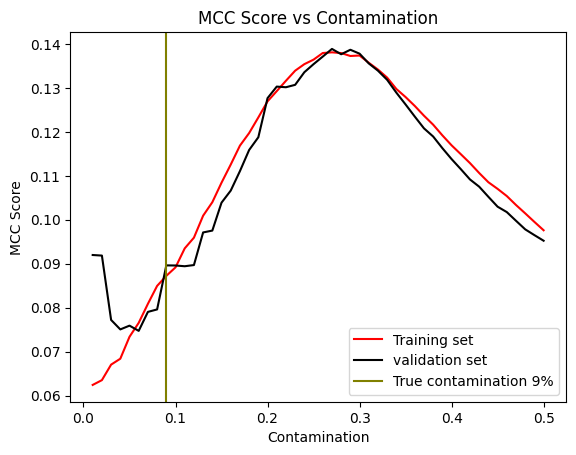

In [650]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
ax.plot(contamination_range, mcc_train, color= 'r', label = 'Training set')
ax.plot(contamination_range, mcc_scores, color= 'black', label = 'validation set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.09, color = 'olive', label = 'True contamination 9%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

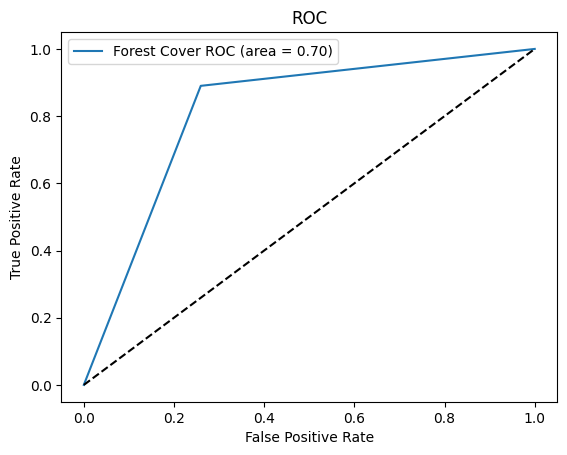

In [651]:
# plot riseiver operating characteristic
fpr5, tpr5, thresholds5 = roc_curve(y_test_cover, y_preds)
roc_auc5 = auc(fpr5, tpr5)
plt.plot(fpr5, tpr5, label='Forest Cover ROC (area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

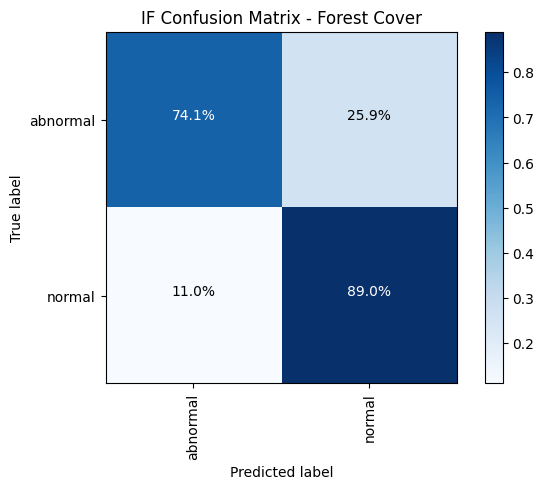

In [652]:
cm = confusion_matrix(y_test_cover, y_preds)
plot_confusion_matrix(cm, title="IF Confusion Matrix - Forest Cover")

## Http(KDDCUP99) dataset

In [653]:
# import the dataset from drive
data = mat73.loadmat('/content/gdrive/MyDrive/Anomaly detection/http.mat')
IF_kdd = data['X']
IF_label_kdd = data['y']

In [654]:
# shape of the data
print('The shape of IF_kdd is: ', IF_kdd.shape)
print('The shape of IF_label_kdd is: ', IF_label_kdd.shape)

The shape of IF_kdd is:  (567498, 3)
The shape of IF_label_kdd is:  (567498,)


In [655]:
# Data description
print('Multi-dimensional point data:\n',IF_kdd)
print('--------------------------')
print('Labels:\n',IF_label_kdd[:5])

Multi-dimensional point data:
 [[-2.30258509  5.37110304 10.71610745]
 [-2.30258509  5.08821343  8.4180577 ]
 [-2.30258509  5.46425544  7.11322354]
 ...
 [-2.30258509  5.38495367  8.19149075]
 [-2.30258509  5.38952825  7.11809724]
 [-2.30258509  5.38952825  7.00133669]]
--------------------------
Labels:
 [0. 0. 0. 0. 0.]


In [656]:
# The amount of normal and anomalies in the dataset
# 0 represents norman, 1 represents anomay
np.unique(IF_label_kdd, return_counts=True)

(array([0., 1.]), array([565287,   2211]))

In [657]:
# Split dataset into training, validation, and testing sets
X_train_kdd, X_val_kdd, y_train_kdd, y_val_kdd = train_test_split(IF_kdd, IF_label_kdd, test_size=0.20, random_state=11)
X_val_kdd, X_test_kdd, y_val_kdd, y_test_kdd = train_test_split(X_val_kdd, y_val_kdd, test_size=0.50, random_state=11)
print("X_train_kdd: ", len(X_train_kdd), "X_val_kdd: ", len(X_val_kdd), "X_test_kdd: ", len(X_test_kdd))
print("y_train_kdd: ", len(y_train_kdd), "y_val_kdd: ", len(y_val_kdd), "y_test_kdd: ", len(y_test_kdd))

X_train_kdd:  453998 X_val_kdd:  56750 X_test_kdd:  56750
y_train_kdd:  453998 y_val_kdd:  56750 y_test_kdd:  56750


In [346]:
# define the contamination range 
contamination_range = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_range:
    # Define and train Isolation Forest model
    model = IsolationForest(random_state=20, contamination=cont, n_estimators=100, max_samples=105)
    model.fit(X_train_kdd, y_train_kdd)
    #make prediction in training set
    val_preds = model.predict(X_train_kdd)
    val_preds = np.where(val_preds == -1, 1, 0)
    MCC = matthews_corrcoef(y_train_kdd, val_preds)
    mcc_train.append(MCC)
    # Make predictions on the validation set
    preds = model.predict(X_val_kdd)
    # convert -1 to 1 and 1 to 0
    y_preds = np.where(preds == -1, 1, 0)
    # Evaluate the performance of the model on validation set
    MCC = matthews_corrcoef(y_val_kdd, y_preds)
    # Append the results to the relevant lists
    mcc_scores.append(MCC)
    contamination.append(cont)
end = datetime.datetime.now()
print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination, 2))
print('--------------------------------------------------------------------------------')
print('Relevant MCC Scores:\n', np.round(mcc_scores, 2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relevant MCC Scores:
 [0.64 0.45 0.37 0.32 0.29 0.26 0.24 0.22 0.21 0.2  0.19 0.18 0.17 0.16
 0.16 0.15 0.15 0.14 0.14 0.13 0.13 0.13 0.12 0.12 0.12 0.11 0.11 0.11
 0.1  0.1  0.1  0.1  0.09 0.09 0.09 0.09 0.09 0.08 0.08 0.08 0.08 0.08
 0.08 0.08 0.07 0.07 0.07 0.07 0.07 0.07]
--------------------------------------------------------------------------------
Execution time is:  0:24:41.462591
--------------------------------------------------------------------------------


In [347]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', np.round(best_contamination,2))

Best Contamination: 0.01


In [348]:
# Train the model on the combined training and validation set
X_train_val_kdd = np.concatenate((X_train_kdd, X_val_kdd))
y_train_val_kdd = np.concatenate((y_train_kdd, y_val_kdd))
model = IsolationForest(random_state=20, contamination=best_contamination, n_estimators=100, max_samples=105)
model.fit(X_train_val_kdd, y_train_val_kdd)

# Make predictions on the testing set
preds = model.predict(X_test_kdd)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_kdd, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 0.6015565433732043


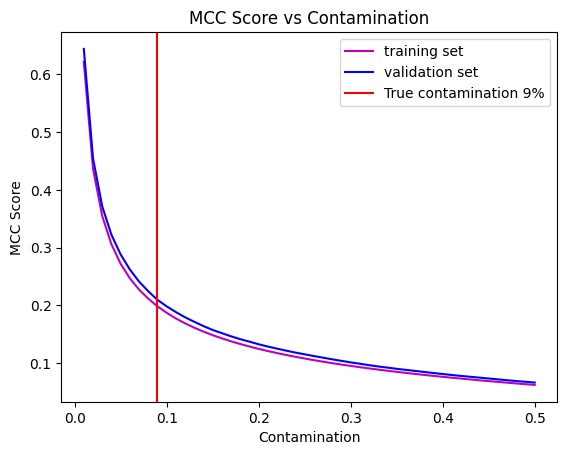

In [349]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
ax.plot(contamination_range, mcc_train, color= 'm', label = 'training set')
ax.plot(contamination_range, mcc_scores, color= 'b', label = 'validation set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.09, color = 'red', label = 'True contamination 9%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

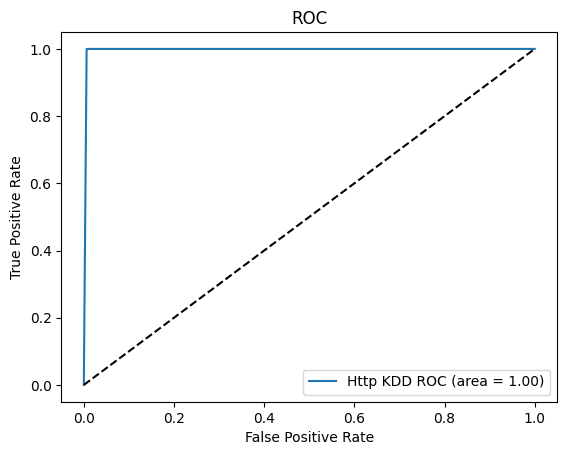

In [350]:
# plot riseiver operating characteristic
fpr6, tpr6, thresholds6 = roc_curve(y_test_kdd, y_preds)
roc_auc6 = auc(fpr6, tpr6)
plt.plot(fpr6, tpr6, label='Http KDD ROC (area = %0.2f)' % roc_auc6)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

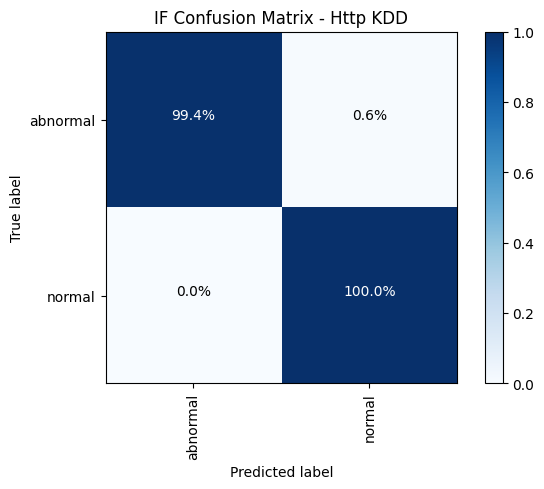

In [351]:
cm = confusion_matrix(y_test_kdd, y_preds)
plot_confusion_matrix(cm, title="IF Confusion Matrix - Http KDD")

## Area Under the Curve for all dataset

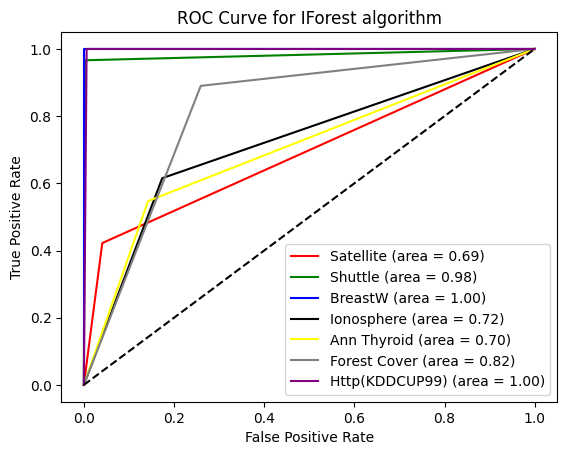

In [658]:
# plotting auc for all 7 dataset
plt.plot(fpr, tpr, color = 'r', label='Satellite (area = %0.2f)' % roc_auc)
plt.plot(fpr1, tpr1, color = 'g', label='Shuttle (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color = 'b', label='BreastW (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color = 'black', label='Ionosphere (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color = 'yellow', label='Ann Thyroid (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color = 'gray', label='Forest Cover (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, color = 'purple', label='Http(KDDCUP99) (area = %0.2f)' % roc_auc6)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for IForest algorithm')
plt.legend()
plt.show()

# Local Outlier Factor

## Satellite dataset

In [94]:
# Loading the dataset from drive
data = scipy.io.loadmat('/content/gdrive/MyDrive/Anomaly detection/satellite.mat')
# isolate the target from the data and assign each in a variable
LOF_sat = data['X']
LOF_label_sat = data['y']

In [95]:
# Split dataset into training, validation, and testing sets
X_train_sat, X_val_sat, y_train_sat, y_val_sat = train_test_split(LOF_sat, LOF_label_sat, test_size=0.20, random_state=11)
X_val_sat, X_test_sat, y_val_sat, y_test_sat = train_test_split(X_val_sat, y_val_sat, test_size=0.50, random_state=11)
print("X_train_sat: ", len(X_train_sat), "X_val_sat: ", len(X_val_sat), "X_test_sat: ", len(X_test_sat))
print("y_train_sat: ", len(y_train_sat), "y_val_sat: ", len(y_val_sat), "y_test_sat: ", len(y_test_sat))

X_train_sat:  5148 X_val_sat:  643 X_test_sat:  644
y_train_sat:  5148 y_val_sat:  643 y_test_sat:  644


In [96]:
# Define a list of contamination values
contamination_values = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_values:
    # Define and train Local Outlier Factor model
      lof = LocalOutlierFactor(n_neighbors=207, contamination=cont, metric='braycurtis')
      lof.fit(X_train_sat, y_train_sat)
      # make prediction in training dataset
      val_preds = lof.fit_predict(X_train_sat)
      val_preds = np.where(val_preds == -1, 1, 0)
      val_MCC = matthews_corrcoef(y_train_sat, val_preds)
      mcc_train.append(val_MCC)
      # Make predictions on the validation set
      y_preds = lof.fit_predict(X_val_sat)
      # convert -1 to 1 and 1 to 0
      y_preds = np.where(y_preds == -1, 1, 0)
      # Evaluate the performance of the model on validation set
      mcc = matthews_corrcoef(y_val_sat, y_preds)
      # Append the results to the relevant lists
      mcc_scores.append(mcc)
      contamination.append(cont)
end = datetime.datetime.now()

print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination,2))
print('--------------------------------------------------------------------------------')
print('Relavent MCC Scores:\n', np.round(mcc_scores,2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relavent MCC Scores:
 [0.16 0.22 0.27 0.31 0.35 0.38 0.41 0.45 0.48 0.51 0.53 0.56 0.57 0.59
 0.6  0.6  0.61 0.6  0.6  0.58 0.57 0.55 0.53 0.53 0.51 0.5  0.48 0.46
 0.44 0.42 0.42 0.4  0.39 0.38 0.37 0.35 0.35 0.33 0.32 0.31 0.3  0.3
 0.29 0.28 0.27 0.26 0.26 0.25 0.24 0.25]
--------------------------------------------------------------------------------
Execution time is:  0:03:27.147008
--------------------------------------------------------------------------------


In [97]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', np.round(best_contamination,2))

Best Contamination: 0.17


In [98]:
# Train the model on the combined training and validation set
X_train_val_sat = np.concatenate((X_train_sat, X_val_sat))
y_train_val_sat = np.concatenate((y_train_sat, y_val_sat))
# Define and train Local Outlier Factor model
lof = LocalOutlierFactor(n_neighbors=207, contamination=best_contamination, metric='braycurtis')
lof.fit(X_train_val_sat, y_train_val_sat)

# Make predictions on the testing set
preds = lof.fit_predict(X_test_sat)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_sat, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 0.5540057623953134


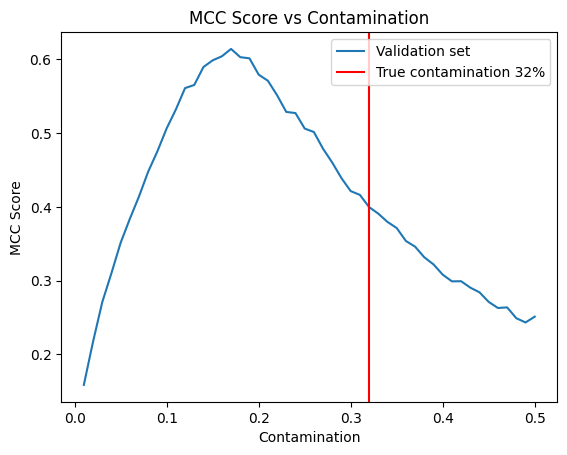

In [99]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
#ax.plot(contamination_values, mcc_train, label = 'Training set')
ax.plot(contamination_values, mcc_scores, label = 'Validation set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.32, color = 'r', label = 'True contamination 32%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

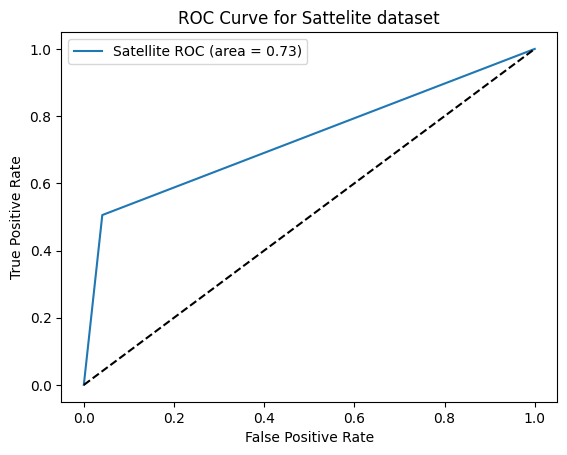

In [100]:
# plot riseiver operating characteristic
fpr, tpr, thresholds = roc_curve(y_test_sat, y_preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='Satellite ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sattelite dataset')
plt.legend()
plt.show()

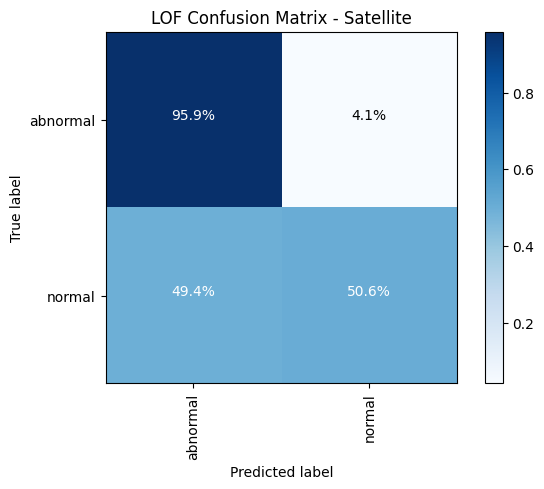

In [101]:
# Plot the confusion metrics
cm = confusion_matrix(y_test_sat, y_preds)
plot_confusion_matrix(cm, title="LOF Confusion Matrix - Satellite")

## Shuttle dataset

In [105]:
# Loading the dataset from drive
data = scipy.io.loadmat('/content/gdrive/MyDrive/Anomaly detection/shuttle.mat')
# isolate the target from the data and assign each in a variable
LOF_shut = data['X']
LOF_label_shut = data['y']

In [106]:
# Split dataset into training, validation, and testing sets
X_train_shut, X_val_shut, y_train_shut, y_val_shut = train_test_split(LOF_shut, LOF_label_shut, test_size=0.20, random_state=11)
X_val_shut, X_test_shut, y_val_shut, y_test_shut = train_test_split(X_val_shut, y_val_shut, test_size=0.50, random_state=11)
print("X_train_shut: ", len(X_train_shut), "X_val_shut: ", len(X_val_shut), "X_test_shut: ", len(X_test_shut))
print("y_train_shut: ", len(y_train_shut), "y_val_shut: ", len(y_val_shut), "y_test_shut: ", len(y_test_shut))

X_train_shut:  39277 X_val_shut:  4910 X_test_shut:  4910
y_train_shut:  39277 y_val_shut:  4910 y_test_shut:  4910


In [107]:
# Define a list of contamination values
contamination_values = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_values:
    # Define and train Local Outlier Factor model
      lof = LocalOutlierFactor(n_neighbors=680, contamination=cont)
      lof.fit(X_train_shut, y_train_shut)
      # make prediction in training dataset
      val_preds = lof.fit_predict(X_train_shut)
      val_preds = np.where(val_preds == -1, 1, 0)
      val_MCC = matthews_corrcoef(y_train_shut, val_preds)
      mcc_train.append(val_MCC)
      # Make predictions on the validation set
      y_preds = lof.fit_predict(X_val_shut)
      # convert -1 to 1 and 1 to 0
      y_preds = np.where(y_preds == -1, 1, 0)
      # Evaluate the performance of the model on validation set
      mcc = matthews_corrcoef(y_val_shut, y_preds)
      # Append the results to the relevant lists
      mcc_scores.append(mcc)
      contamination.append(cont)
end = datetime.datetime.now()

print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination,2))
print('--------------------------------------------------------------------------------')
print('Relavent MCC Scores:\n', np.round(mcc_scores,2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relavent MCC Scores:
 [0.2  0.4  0.53 0.65 0.75 0.84 0.92 0.91 0.86 0.81 0.77 0.73 0.7  0.67
 0.65 0.62 0.6  0.58 0.56 0.55 0.53 0.51 0.5  0.49 0.47 0.46 0.45 0.44
 0.43 0.42 0.41 0.4  0.39 0.38 0.37 0.36 0.36 0.35 0.34 0.33 0.33 0.32
 0.31 0.31 0.3  0.3  0.29 0.28 0.28 0.27]
--------------------------------------------------------------------------------
Execution time is:  0:55:50.857457
--------------------------------------------------------------------------------


In [108]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', np.round(best_contamination,2))

Best Contamination: 0.07


In [109]:
# Train the model on the combined training and validation set
X_train_val_shut = np.concatenate((X_train_shut, X_val_shut))
y_train_val_shut = np.concatenate((y_train_shut, y_val_shut))
# Define and train Local Outlier Factor model
lof = LocalOutlierFactor(n_neighbors=680, contamination=best_contamination)#, metric='braycurtis')
lof.fit(X_train_val_shut, y_train_val_shut)

# Make predictions on the testing set
preds = lof.fit_predict(X_test_shut)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_shut, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 0.8882472939053934


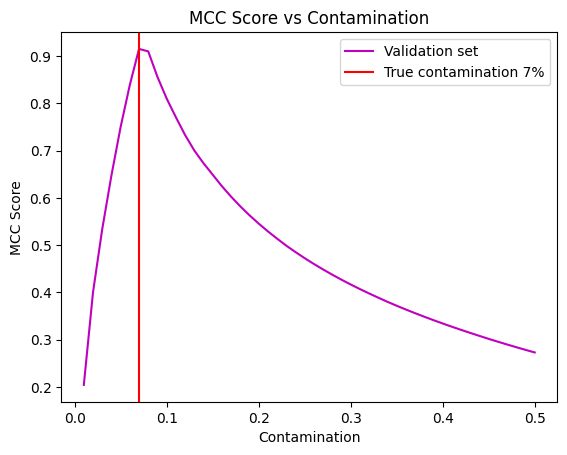

In [113]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
#ax.plot(contamination_values, mcc_train, color = 'black', label = 'Training set')
ax.plot(contamination_values, mcc_scores, color= 'm', label = 'Validation set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.07, color = 'r', label = 'True contamination 7%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

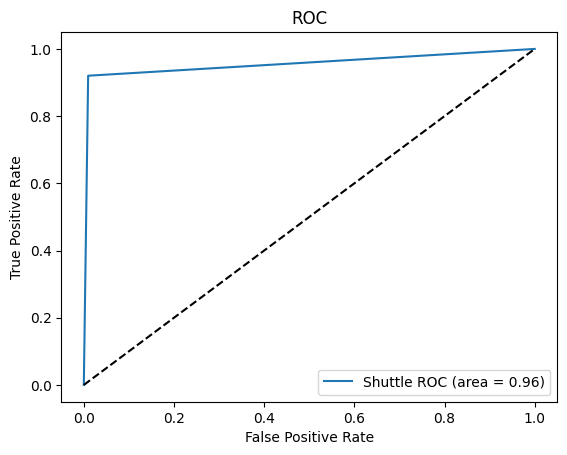

In [111]:
# plot riseiver operating characteristic
fpr1, tpr1, thresholds1 = roc_curve(y_test_shut, y_preds)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Shuttle ROC (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

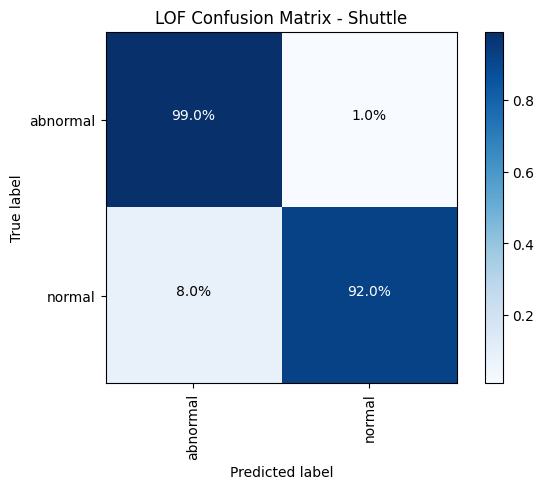

In [112]:
# plot confusion metrics
cm = confusion_matrix(y_test_shut, y_preds)
plot_confusion_matrix(cm, title="LOF Confusion Matrix - Shuttle")

## Breast dataset

In [5]:
# Loading the dataset from drive
data = scipy.io.loadmat('/content/gdrive/MyDrive/Anomaly detection/breastw.mat')
# isolate the target from the data and assign each in a variable
LOF_breast = data['X']
LOF_label_breast = data['y']

In [6]:
# Split dataset into training, validation, and testing sets
X_train_breast, X_val_breast, y_train_breast, y_val_breast = train_test_split(LOF_breast, LOF_label_breast, test_size=0.20, random_state=11)
X_val_breast, X_test_breast, y_val_breast, y_test_breast = train_test_split(X_val_breast, y_val_breast, test_size=0.50, random_state=11)
print("X_train_breast: ", len(X_train_breast), "X_val_breast: ", len(X_val_breast), "X_test_breast: ", len(X_test_breast))
print("y_train_breast: ", len(y_train_breast), "y_val_breast: ", len(y_val_breast), "y_test_breast: ", len(y_test_breast))

X_train_breast:  546 X_val_breast:  68 X_test_breast:  69
y_train_breast:  546 y_val_breast:  68 y_test_breast:  69


In [19]:
# Define a list of contamination values
contamination_values = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_values:
    # Define and train Local Outlier Factor model
      lof = LocalOutlierFactor(n_neighbors=55, contamination=cont)
      lof.fit(X_train_breast, y_train_breast)
      # make prediction in training dataset
      val_preds = lof.fit_predict(X_train_breast)
      val_preds = np.where(val_preds == -1, 1, 0)
      val_MCC = matthews_corrcoef(y_train_breast, val_preds)
      mcc_train.append(val_MCC)
      # Make predictions on the validation set
      y_preds = lof.fit_predict(X_val_breast)
      # convert -1 to 1 and 1 to 0
      y_preds = np.where(y_preds == -1, 1, 0)
      # Evaluate the performance of the model on validation set
      mcc = matthews_corrcoef(y_val_breast, y_preds)
      # Append the results to the relevant lists
      mcc_scores.append(mcc)
      contamination.append(cont)
end = datetime.datetime.now()

print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination,2))
print('--------------------------------------------------------------------------------')
print('Relavent MCC Scores:\n', np.round(mcc_scores,2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relavent MCC Scores:
 [0.17 0.24 0.3  0.3  0.35 0.39 0.39 0.44 0.47 0.47 0.51 0.55 0.55 0.58
 0.61 0.61 0.65 0.68 0.68 0.71 0.74 0.74 0.7  0.74 0.74 0.77 0.73 0.73
 0.77 0.8  0.8  0.83 0.87 0.87 0.9  0.94 0.94 0.94 0.88 0.88 0.85 0.83
 0.83 0.8  0.78 0.78 0.76 0.74 0.74 0.71]
--------------------------------------------------------------------------------
Execution time is:  0:00:02.903377
--------------------------------------------------------------------------------


In [20]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', np.round(best_contamination,2))

Best Contamination: 0.36


In [21]:
# Train the model on the combined training and validation set
X_train_val_breast = np.concatenate((X_train_breast, X_val_breast))
y_train_val_breast = np.concatenate((y_train_breast, y_val_breast))
# Define and train Local Outlier Factor model
lof = LocalOutlierFactor(n_neighbors=55, contamination=best_contamination)
lof.fit(X_train_val_breast, y_train_val_breast)

# Make predictions on the testing set
preds = lof.fit_predict(X_test_breast)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_breast, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 0.8507277623828584


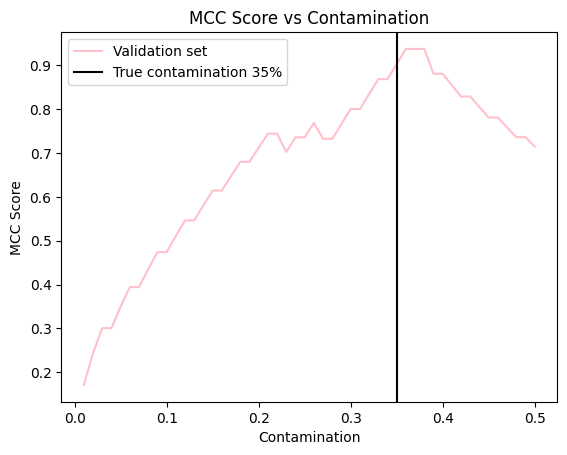

In [22]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
#ax.plot(contamination_values, mcc_train, color = 'green', label = 'Training set')
ax.plot(contamination_values, mcc_scores, color= 'pink', label = 'Validation set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.35, color = 'black', label = 'True contamination 35%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

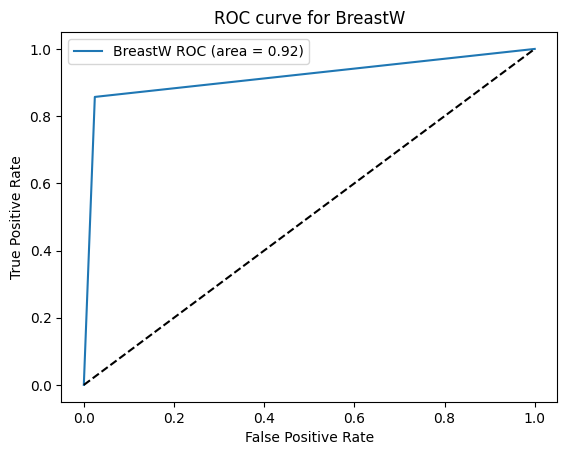

In [23]:
# plot riseiver operating characteristic
fpr2, tpr2, thresholds2 = roc_curve(y_test_breast, y_preds)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='BreastW ROC (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for BreastW')
plt.legend()
plt.show()

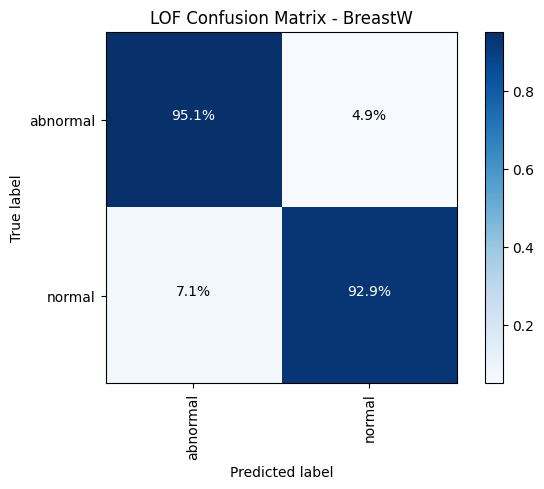

In [693]:
# plot confusion metrics
cm = confusion_matrix(y_test_breast, y_preds)
plot_confusion_matrix(cm, title="LOF Confusion Matrix - BreastW")

## Ionosphere dataset

In [24]:
# Loading the dataset from drive
data = scipy.io.loadmat('/content/gdrive/MyDrive/Anomaly detection/ionosphere.mat')
# isolate the target from the data and assign each in a variable
LOF_ion = data['X']
LOF_label_ion = data['y']

In [25]:
# Split dataset into training, validation, and testing sets
X_train_ion, X_val_ion, y_train_ion, y_val_ion = train_test_split(LOF_ion, LOF_label_ion, test_size=0.20, random_state=11)
X_val_ion, X_test_ion, y_val_ion, y_test_ion = train_test_split(X_val_ion, y_val_ion, test_size=0.50, random_state=11)
print("X_train_ion: ", len(X_train_ion), "X_val_ion: ", len(X_val_ion), "X_test_ion: ", len(X_test_ion))
print("y_train_ion: ", len(y_train_ion), "y_val_ion: ", len(y_val_ion), "y_test_ion: ", len(y_test_ion))

X_train_ion:  280 X_val_ion:  35 X_test_ion:  36
y_train_ion:  280 y_val_ion:  35 y_test_ion:  36


In [26]:
# Define a list of contamination values
contamination_values = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_values:
    # Define and train Local Outlier Factor model
      lof = LocalOutlierFactor(n_neighbors=5, contamination=cont)
      lof.fit(X_train_ion, y_train_ion)
      # make prediction in training dataset
      val_preds = lof.fit_predict(X_train_ion)
      val_preds = np.where(val_preds == -1, 1, 0)
      val_MCC = matthews_corrcoef(y_train_ion, val_preds)
      mcc_train.append(val_MCC)
      # Make predictions on the validation set
      y_preds = lof.fit_predict(X_val_ion)
      # convert -1 to 1 and 1 to 0
      y_preds = np.where(y_preds == -1, 1, 0)
      # Evaluate the performance of the model on validation set
      mcc = matthews_corrcoef(y_val_ion, y_preds)
      # Append the results to the relevant lists
      mcc_scores.append(mcc)
      contamination.append(cont)
end = datetime.datetime.now()

print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination,2))
print('--------------------------------------------------------------------------------')
print('Relavent MCC Scores:\n', np.round(mcc_scores,2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relavent MCC Scores:
 [0.22 0.22 0.32 0.32 0.32 0.4  0.4  0.4  0.47 0.47 0.47 0.53 0.53 0.53
 0.59 0.59 0.59 0.65 0.65 0.65 0.71 0.71 0.71 0.77 0.77 0.77 0.82 0.82
 0.82 0.88 0.88 0.88 0.82 0.82 0.82 0.76 0.76 0.76 0.7  0.7  0.7  0.77
 0.77 0.77 0.72 0.72 0.72 0.67 0.67 0.67]
--------------------------------------------------------------------------------
Execution time is:  0:00:00.672610
--------------------------------------------------------------------------------


In [27]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', np.round(best_contamination,2))

Best Contamination: 0.3


In [28]:
# Train the model on the combined training and validation set
X_train_val_ion = np.concatenate((X_train_ion, X_val_ion))
y_train_val_ion = np.concatenate((y_train_ion, y_val_ion))
# Define and train Local Outlier Factor model
lof = LocalOutlierFactor(n_neighbors=5, contamination=best_contamination)
lof.fit(X_train_val_ion, y_train_val_ion)

# Make predictions on the testing set
preds = lof.fit_predict(X_test_ion)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_ion, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 0.5056686869069631


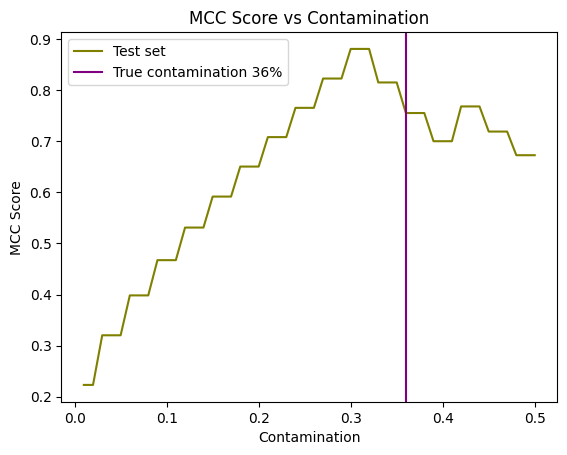

In [30]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
#ax.plot(contamination_values, mcc_train, color = 'lime', label = 'Training set')
ax.plot(contamination_values, mcc_scores, color= 'olive', label = 'Test set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.36, color = 'purple', label = 'True contamination 36%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

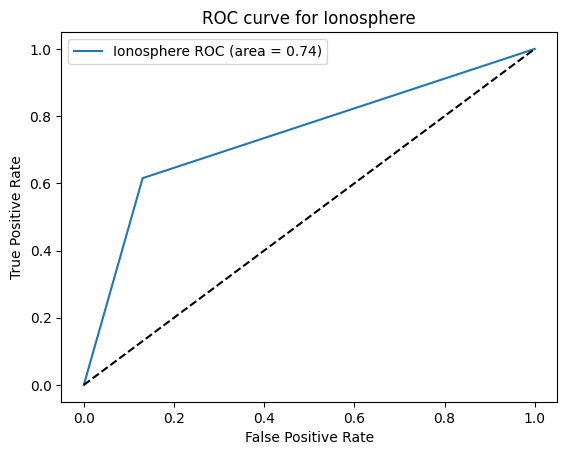

In [31]:
# plot riseiver operating characteristic
fpr3, tpr3, thresholds3 = roc_curve(y_test_ion, y_preds)
roc_auc3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Ionosphere ROC (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Ionosphere')
plt.legend()
plt.show()

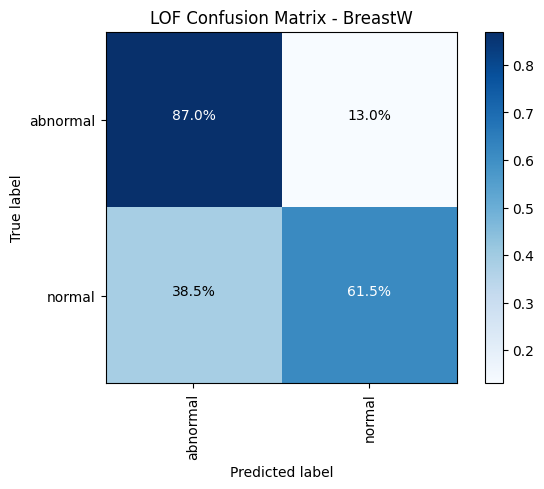

In [32]:
# plot confusion metrics
cm = confusion_matrix(y_test_ion, y_preds)
plot_confusion_matrix(cm, title="LOF Confusion Matrix - BreastW")

## AnnThyroid dataset

In [33]:
# Loading the dataset from drive
data = scipy.io.loadmat('/content/gdrive/MyDrive/Anomaly detection/annthyroid.mat')
# isolate the target from the data and assign each in a variable
LOF_ann = data['X']
LOF_label_ann = data['y']

In [34]:
# Split dataset into training, validation, and testing sets
X_train_ann, X_val_ann, y_train_ann, y_val_ann = train_test_split(LOF_ann, LOF_label_ann, test_size=0.20, random_state=11)
X_val_ann, X_test_ann, y_val_ann, y_test_ann = train_test_split(X_val_ann, y_val_ann, test_size=0.50, random_state=11)
print("X_train_ann: ", len(X_train_ann), "X_val_ann: ", len(X_val_ann), "X_test_ann: ", len(X_test_ann))
print("y_train_ann: ", len(y_train_ann), "y_val_ann: ", len(y_val_ann), "y_test_ann: ", len(y_test_ann))

X_train_ann:  5760 X_val_ann:  720 X_test_ann:  720
y_train_ann:  5760 y_val_ann:  720 y_test_ann:  720


In [355]:
# Define a list of contamination values
contamination_values = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_values:
    # Define and train Local Outlier Factor model
      lof = LocalOutlierFactor(n_neighbors=45, contamination=cont)
      lof.fit(X_train_ann, y_train_ann)
      # make prediction in training dataset
      val_preds = lof.fit_predict(X_train_ann)
      val_preds = np.where(val_preds == -1, 1, 0)
      val_MCC = matthews_corrcoef(y_train_ann, val_preds)
      mcc_train.append(val_MCC)
      # Make predictions on the validation set
      y_preds = lof.fit_predict(X_val_ann)
      # convert -1 to 1 and 1 to 0
      y_preds = np.where(y_preds == -1, 1, 0)
      # Evaluate the performance of the model on validation set
      mcc = matthews_corrcoef(y_val_ann, y_preds)
      # Append the results to the relevant lists
      mcc_scores.append(mcc)
      contamination.append(cont)
end = datetime.datetime.now()

print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination,2))
print('--------------------------------------------------------------------------------')
print('Relavent MCC Scores:\n', np.round(mcc_scores,2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relavent MCC Scores:
 [0.23 0.33 0.32 0.27 0.23 0.2  0.17 0.17 0.16 0.14 0.12 0.13 0.13 0.12
 0.12 0.11 0.12 0.11 0.11 0.1  0.12 0.14 0.14 0.16 0.15 0.14 0.14 0.14
 0.13 0.13 0.14 0.13 0.13 0.14 0.13 0.13 0.13 0.13 0.13 0.13 0.14 0.13
 0.13 0.12 0.11 0.11 0.1  0.12 0.11 0.12]
--------------------------------------------------------------------------------
Execution time is:  0:00:10.034223
--------------------------------------------------------------------------------


In [35]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', np.round(best_contamination,2))

Best Contamination: 0.3


In [37]:
# Train the model on the combined training and validation set
X_train_val_ann = np.concatenate((X_train_ann, X_val_ann))
y_train_val_ann = np.concatenate((y_train_ann, y_val_ann))
# Define and train Local Outlier Factor model
lof = LocalOutlierFactor(n_neighbors=45, contamination=best_contamination)
lof.fit(X_train_val_ion, y_train_val_ann)

# Make predictions on the testing set
preds = lof.fit_predict(X_test_ann)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_ann, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 0.09401010110485106


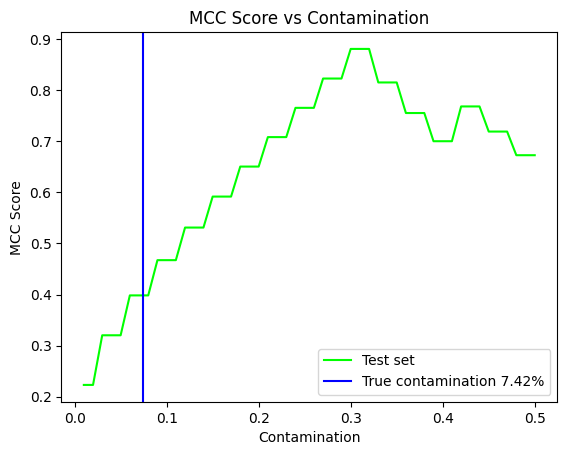

In [42]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
#ax.plot(contamination, mcc_train, color = 'r', label = 'Training set')
ax.plot(contamination, mcc_scores, color= 'lime', label = 'Test set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.0742, color = 'b', label = 'True contamination 7.42%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

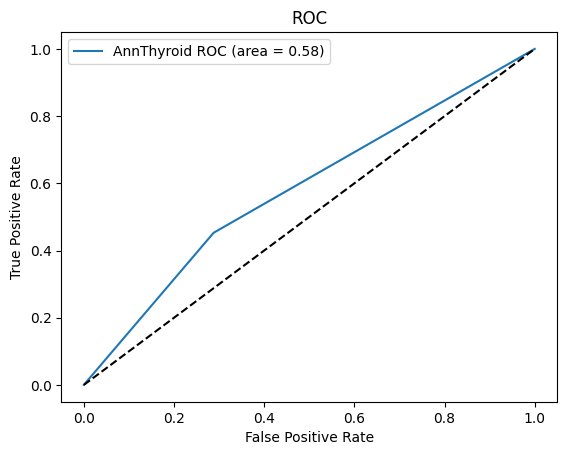

In [41]:
# plot riseiver operating characteristic
fpr4, tpr4, thresholds4 = roc_curve(y_test_ann, y_preds)
roc_auc4 = auc(fpr4, tpr4)
plt.plot(fpr4, tpr4, label='AnnThyroid ROC (area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

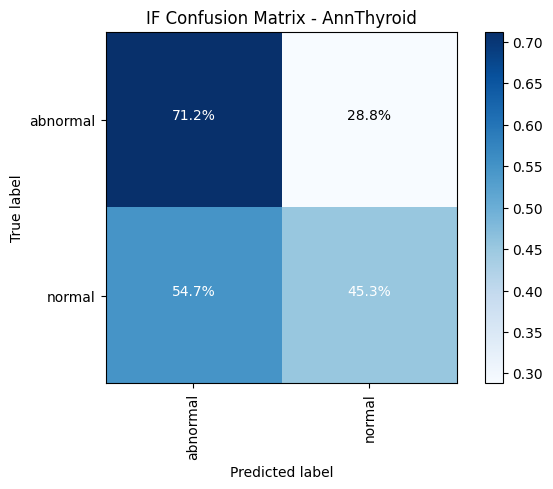

In [43]:
cm = confusion_matrix(y_test_ann, y_preds)
plot_confusion_matrix(cm, title="IF Confusion Matrix - AnnThyroid")

## Forrest Cover dataset

In [73]:
# Loading the dataset from drive
data = scipy.io.loadmat('/content/gdrive/MyDrive/Anomaly detection/cover.mat')
# isolate the target from the data and assign each in a variable
LOF_cover = data['X']
LOF_label_cover = data['y']

In [74]:
# Split dataset into training, validation, and testing sets
X_train_cover, X_val_cover, y_train_cover, y_val_cover = train_test_split(LOF_cover, LOF_label_cover, test_size=0.20, random_state=11)
X_val_cover, X_test_cover, y_val_cover, y_test_cover = train_test_split(X_val_cover, y_val_cover, test_size=0.50, random_state=11)
print("X_train_cover: ", len(X_train_cover), "X_val_cover: ", len(X_val_cover), "X_test_cover: ", len(X_test_cover))
print("y_train_cover: ", len(y_train_cover), "y_val_cover: ", len(y_val_cover), "y_test_cover: ", len(y_test_cover))

X_train_cover:  228838 X_val_cover:  28605 X_test_cover:  28605
y_train_cover:  228838 y_val_cover:  28605 y_test_cover:  28605


In [75]:
# Define a list of contamination values
contamination_values = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_values:
    # Define and train Local Outlier Factor model
      lof = LocalOutlierFactor(n_neighbors=200, contamination=cont)
      lof.fit(X_train_cover, y_train_cover)
      # make prediction in training dataset
      val_preds = lof.fit_predict(X_train_cover)
      val_preds = np.where(val_preds == -1, 1, 0)
      val_MCC = matthews_corrcoef(y_train_cover, val_preds)
      mcc_train.append(val_MCC)
      # Make predictions on the validation set
      y_preds = lof.fit_predict(X_val_cover)
      # convert -1 to 1 and 1 to 0
      y_preds = np.where(y_preds == -1, 1, 0)
      # Evaluate the performance of the model on validation set
      mcc = matthews_corrcoef(y_val_cover, y_preds)
      # Append the results to the relevant lists
      mcc_scores.append(mcc)
      contamination.append(cont)
end = datetime.datetime.now()

print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination,2))
print('--------------------------------------------------------------------------------')
print('Relavent MCC Scores:\n', np.round(mcc_scores,2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relavent MCC Scores:
 [0.36 0.39 0.37 0.35 0.33 0.32 0.3  0.28 0.27 0.26 0.25 0.24 0.23 0.22
 0.21 0.21 0.2  0.2  0.19 0.19 0.18 0.18 0.17 0.17 0.16 0.16 0.15 0.15
 0.15 0.14 0.14 0.14 0.13 0.13 0.13 0.13 0.12 0.12 0.12 0.12 0.11 0.11
 0.11 0.11 0.11 0.1  0.1  0.1  0.1  0.1 ]
--------------------------------------------------------------------------------
Execution time is:  1:56:39.156720
--------------------------------------------------------------------------------


In [76]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', np.round(best_contamination,2))

Best Contamination: 0.02


In [77]:
# Train the model on the combined training and validation set
X_train_val_cover = np.concatenate((X_train_cover, X_val_cover))
y_train_val_cover = np.concatenate((y_train_cover, y_val_cover))
# Define and train Local Outlier Factor model
lof = LocalOutlierFactor(n_neighbors=200, contamination=best_contamination)
lof.fit(X_train_val_ion, y_train_val_cover)

# Make predictions on the testing set
preds = lof.fit_predict(X_test_cover)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_cover, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 0.41198146788616


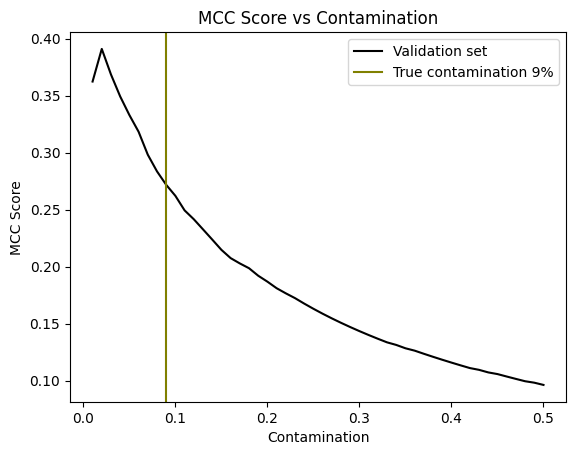

In [80]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
#ax.plot(contamination_values, mcc_train, color = 'pink', label = 'Training set')
ax.plot(contamination_values, mcc_scores, color= 'black', label = 'Validation set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.09, color = 'olive', label = 'True contamination 9%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

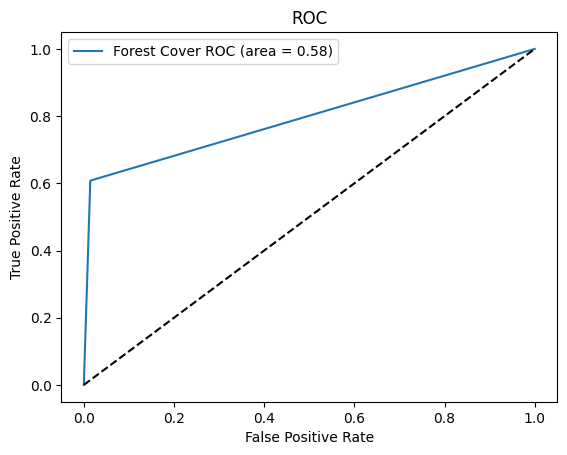

In [81]:
# plot riseiver operating characteristic
fpr5, tpr5, thresholds5 = roc_curve(y_test_cover, y_preds)
roc_auc5 = auc(fpr5, tpr5)
plt.plot(fpr5, tpr5, label='Forest Cover ROC (area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

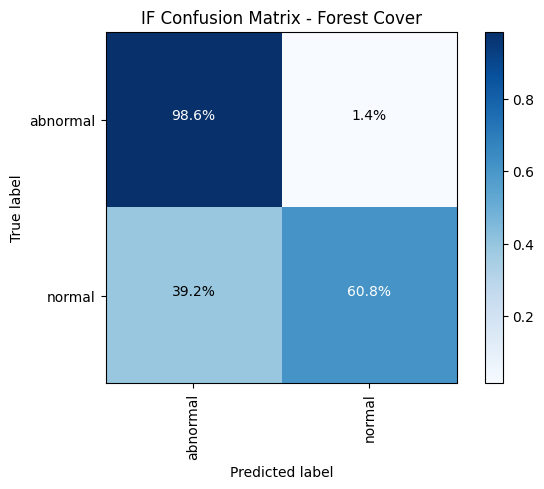

In [82]:
cm = confusion_matrix(y_test_cover, y_preds)
plot_confusion_matrix(cm, title="IF Confusion Matrix - Forest Cover")

## Http(KDDCUP99) dataset

In [114]:
# import the dataset from drive
data = mat73.loadmat('/content/gdrive/MyDrive/Anomaly detection/http.mat')
LOF_kdd = data['X']
LOF_label_kdd = data['y']

In [115]:
# Split dataset into training, validation, and testing sets
X_train_kdd, X_val_kdd, y_train_kdd, y_val_kdd = train_test_split(LOF_kdd, LOF_label_kdd, test_size=0.20, random_state=11)
X_val_kdd, X_test_kdd, y_val_kdd, y_test_kdd = train_test_split(X_val_kdd, y_val_kdd, test_size=0.50, random_state=11)
print("X_train_kdd: ", len(X_train_kdd), "X_val_kdd: ", len(X_val_kdd), "X_test_kdd: ", len(X_test_kdd))
print("y_train_kdd: ", len(y_train_kdd), "y_val_kdd: ", len(y_val_kdd), "y_test_kdd: ", len(y_test_kdd))

X_train_kdd:  453998 X_val_kdd:  56750 X_test_kdd:  56750
y_train_kdd:  453998 y_val_kdd:  56750 y_test_kdd:  56750


In [117]:
# Define a list of contamination values
contamination_values = np.linspace(0.01, 0.50, 50)

# Initialize empty lists to store contaminations and relevant MCC scores
mcc_scores = []
contamination = []
mcc_train = []
# For loop over different contamination levels and evaluate the model
start = datetime.datetime.now()
for cont in contamination_values:
    # Define and train Local Outlier Factor model
      lof = LocalOutlierFactor(n_neighbors=300, contamination=cont)
      lof.fit(X_train_cover, y_train_cover)
      # make prediction in training dataset
      val_preds = lof.fit_predict(X_train_kdd)
      val_preds = np.where(val_preds == -1, 1, 0)
      val_MCC = matthews_corrcoef(y_train_kdd, val_preds)
      mcc_train.append(val_MCC)
      # Make predictions on the validation set
      y_preds = lof.fit_predict(X_val_cover)
      # convert -1 to 1 and 1 to 0
      y_preds = np.where(y_preds == -1, 1, 0)
      # Evaluate the performance of the model on validation set
      mcc = matthews_corrcoef(y_val_cover, y_preds)
      # Append the results to the relevant lists
      mcc_scores.append(mcc)
      contamination.append(cont)
end = datetime.datetime.now()

print('--------------------------------------------------------------------------------')
print('Different contaminations:\n', np.round(contamination,2))
print('--------------------------------------------------------------------------------')
print('Relavent MCC Scores:\n', np.round(mcc_scores,2))
print('--------------------------------------------------------------------------------')
print('Execution time is: ', (end - start))
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
Different contaminations:
 [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
--------------------------------------------------------------------------------
Relavent MCC Scores:
 [0.29 0.34 0.35 0.33 0.31 0.29 0.29 0.28 0.27 0.26 0.24 0.23 0.23 0.22
 0.21 0.21 0.2  0.2  0.19 0.19 0.18 0.18 0.17 0.17 0.16 0.16 0.15 0.15
 0.15 0.14 0.14 0.14 0.13 0.13 0.13 0.13 0.12 0.12 0.12 0.12 0.11 0.11
 0.11 0.11 0.11 0.1  0.1  0.1  0.1  0.1 ]
--------------------------------------------------------------------------------
Execution time is:  2:38:44.157519
--------------------------------------------------------------------------------


In [118]:
# Find the best contamination value based on validation results
best_index = np.argmax(mcc_scores)
best_contamination = contamination[best_index]
print('Best Contamination:', np.round(best_contamination,2))

Best Contamination: 0.03


In [123]:
# Train the model on the combined training and validation set
X_train_val_kdd = np.concatenate((X_train_kdd, X_val_kdd))
y_train_val_kdd = np.concatenate((y_train_kdd, y_val_kdd))
lof = LocalOutlierFactor(n_neighbors=300, contamination=best_contamination)
lof.fit(X_train_cover, y_train_cover)

# Make predictions on the testing set
preds = lof.fit_predict(X_test_kdd)
# Convert -1 to 1 and 1 to 0
y_preds = np.where(preds == -1, 1, 0)
# Evaluate the performance of the model on the testing set
MCC = matthews_corrcoef(y_test_kdd, y_preds)
print('MCC on testing set:', MCC)

MCC on testing set: 0.3342484481905383


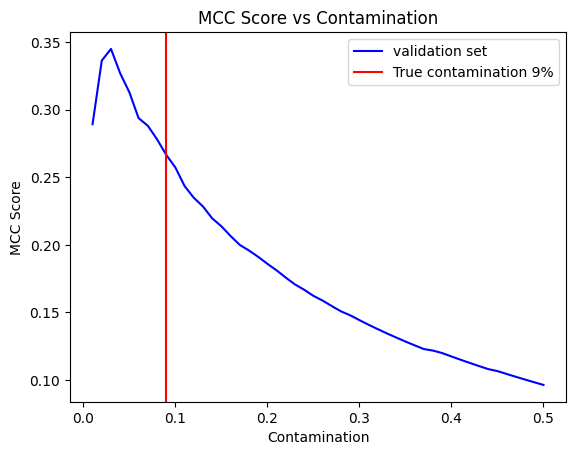

In [124]:
# Plot the relation between MCC and contamination
fig,ax = plt.subplots()
#ax.plot(contamination_values, mcc_train, color= 'm', label = 'training set')
ax.plot(contamination_values, mcc_scores, color= 'b', label = 'validation set')
# Plot the ture contamination of the dataset
ax.axvline(x = 0.09, color = 'red', label = 'True contamination 9%')
plt.xlabel('Contamination')
plt.ylabel('MCC Score')
plt.title('MCC Score vs Contamination')
plt.legend()
plt.show()

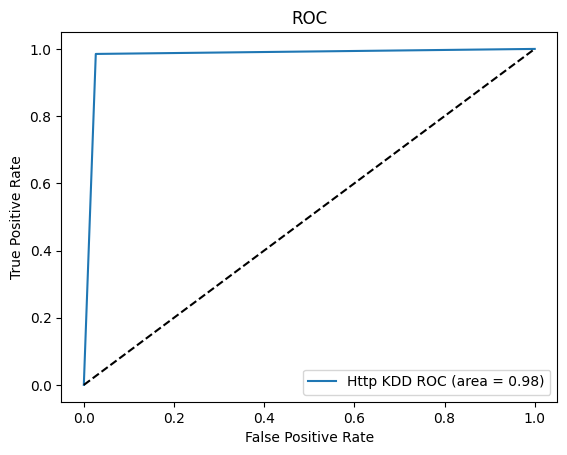

In [125]:
# plot riseiver operating characteristic
fpr6, tpr6, thresholds6 = roc_curve(y_test_kdd, y_preds)
roc_auc6 = auc(fpr6, tpr6)
plt.plot(fpr6, tpr6, label='Http KDD ROC (area = %0.2f)' % roc_auc6)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

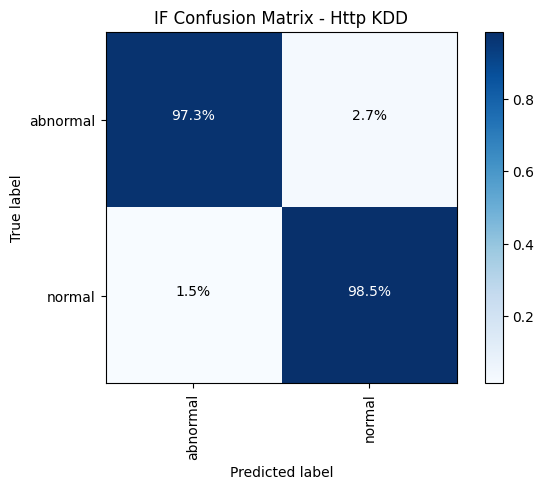

In [126]:
cm = confusion_matrix(y_test_kdd, y_preds)
plot_confusion_matrix(cm, title="IF Confusion Matrix - Http KDD")

## Area Under the Curve for all dataset

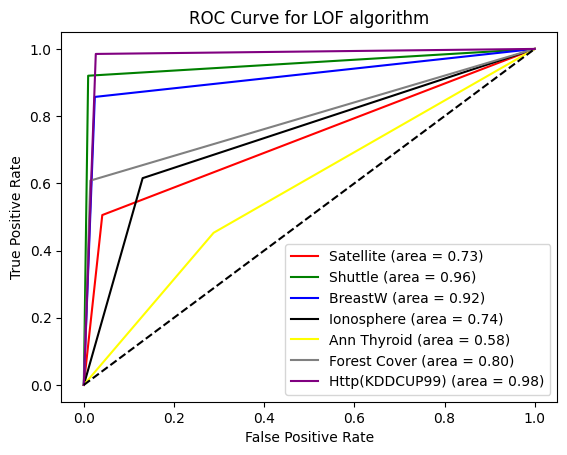

In [127]:
# plotting auc for all 7 dataset
plt.plot(fpr, tpr, color = 'r', label='Satellite (area = %0.2f)' % roc_auc)
plt.plot(fpr1, tpr1, color = 'g', label='Shuttle (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color = 'b', label='BreastW (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color = 'black', label='Ionosphere (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color = 'yellow', label='Ann Thyroid (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color = 'gray', label='Forest Cover (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, color = 'purple', label='Http(KDDCUP99) (area = %0.2f)' % roc_auc6)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LOF algorithm')
plt.legend()
plt.show()